In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helpers as hp
import stationary as st
import plotresults as pr
import panelvar as pvar
import deepvar
import var
import lstm
import warnings 
import irf

warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but StandardScaler was fitted with feature names')
warnings.filterwarnings('ignore', message='An unsupported index was provided and will be ignored when e.g. forecasting.')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prepare_df(df):
    df['log_GDP'] = np.log(df['GDP']) 
    df['log_CPI'] = np.log(df['CPI']) 
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP", 'CPI'})
    return final_df



Basic VAR detrend results

In [3]:
df = pd.read_csv('./Data/WithoutPolicyRate.csv')

variables_to_keep = ['log_GDP', 'household_debt', 'private_debt']


In [4]:
df = prepare_df(df)
# pr_df = prepare_df(pr_df)
df = df.drop(columns = {"exchange_rate"})
df = df[variables_to_keep]
LAGS = 1



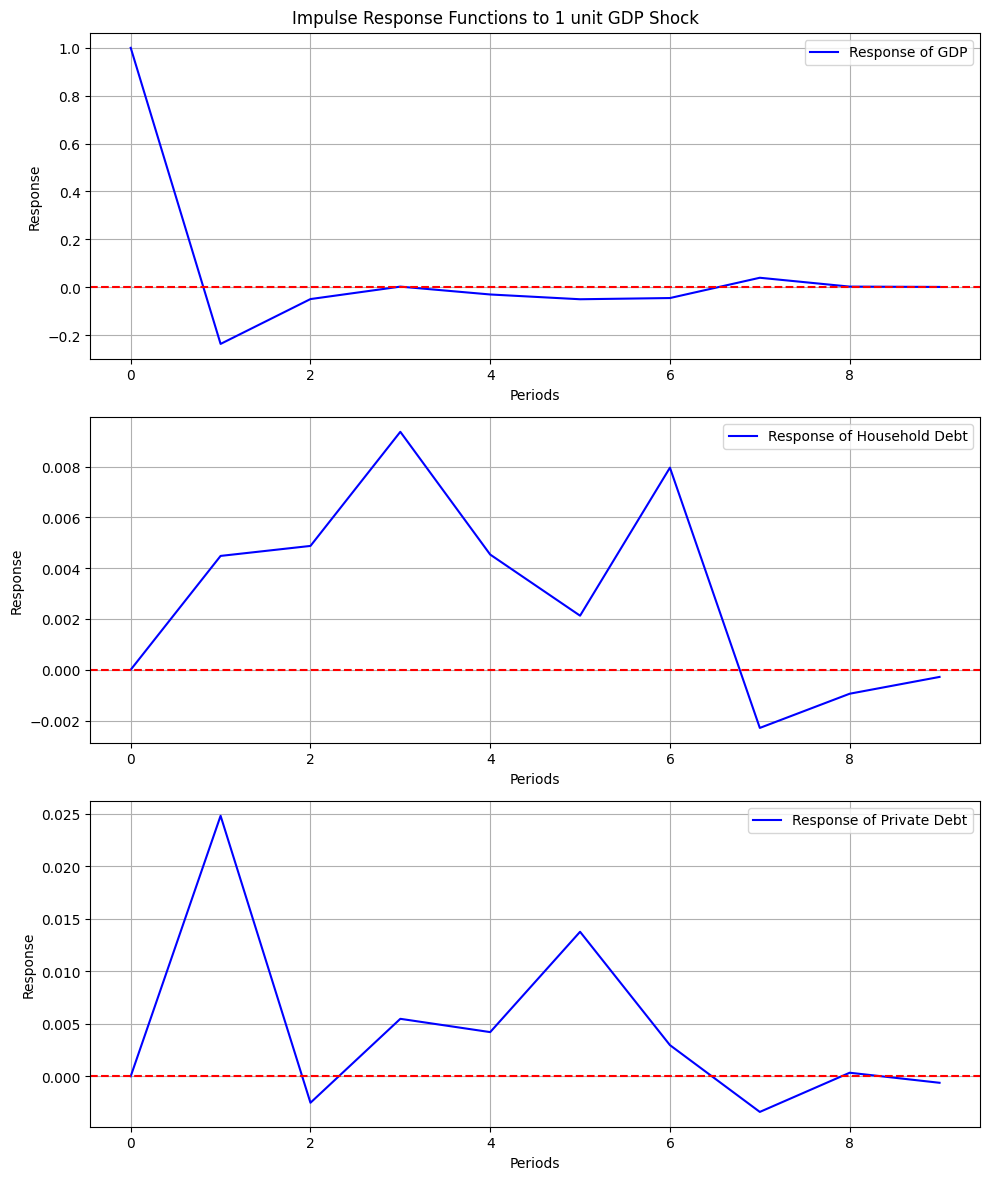

In [5]:
# Get PVAR Coefficients
pvar_dict = {
    1: 'coef1.xlsx',
    2: 'coef2.xlsx',
    3: 'coef3.xlsx',
    4: 'coef4.xlsx',
    5: 'coef5.xlsx',
    6: 'coef6.xlsx',
}
file = pvar_dict.get(LAGS)

panel_var_coef = pd.read_excel('coef6.xlsx', index_col=0)
panel_var_coef 

fig, irf_results = pvar.generate_irf_from_coefficients(
    panel_var_coef,
    shock_var=0, 
    shock_size=1,  
    periods=10
)


In [6]:
variables = df.columns
final_detrend = st.detrend_data(df, variables, 1) 
final_detrend = final_detrend[final_detrend.index.get_level_values("TIME_PERIOD")< "2020-03-31"]
# countries_to_drop = ['Argentina', 'Türkiye, Rep of',  'Ireland']
# final_detrend =  final_detrend[~final_detrend.index.get_level_values('Country').isin(countries_to_drop)]

Index(['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Ireland', 'Germany',
       'Brazil', 'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Argentina',
       'Singapore', 'France', 'Portugal', 'Hungary', 'Spain', 'Canada',
       'Switzerland', 'United States', 'Denmark', 'Indonesia',
       'China, P.R.: Hong Kong', 'Luxembourg', 'Japan', 'Finland',
       'South Africa', 'Chile', 'Czech Rep.', 'Poland, Rep. of',
       'Türkiye, Rep of', 'Korea, Rep. of', 'Belgium'],
      dtype='object', name='Country')


In [7]:
train_dt_var, test_dt_var = hp.time_panel_split_predict(final_detrend)
excluding_outlier = hp.exclude_country(final_detrend,"Indonesia")
excluding_outliers = hp.exclude_country(final_detrend,"India")
eo_train_dt_var, eo_test_dt_var = hp.time_panel_split_predict(excluding_outliers)

lstm_df= lstm.create_lstm_data(final_detrend, LAGS)

inputs = lstm.get_lstm_input(final_detrend, LAGS)
lstm_train, lstm_val, lstm_test= lstm.train_val_test_split(lstm_df)


In [8]:
num_unique_countries = len(final_detrend.index.get_level_values("Country").unique())
print("Countries", num_unique_countries)
print("Number of obsevations", len(final_detrend))
# all_lstm_data.index.get_level_values("TIME_PERIOD").unique().sort_values()

Countries 39
Number of obsevations 4065


In [9]:
final_detrend.describe()

summary_stats = final_detrend.describe().transpose()

latex_table = summary_stats.to_latex(float_format="%.5f")

# Print the LaTeX code (you can copy this directly into your LaTeX document)
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
log_GDP & 4065.00000 & 0.00655 & 0.01158 & -0.07151 & 0.00156 & 0.00685 & 0.01185 & 0.18761 \\
household_debt & 4065.00000 & 0.25376 & 0.82540 & -8.50000 & -0.20000 & 0.20000 & 0.70000 & 4.40000 \\
private_debt & 4065.00000 & 0.33748 & 3.08540 & -30.20000 & -0.70000 & 0.20000 & 1.10000 & 105.80000 \\
\bottomrule
\end{tabular}



In [10]:
# all_lstm_data[all_lstm_data['private_debt']>10]
# # Ireland 2015 corporate debt restructuring. Should I omit?
# all_lstm_data[all_lstm_data['CPI']>10]
# #  Turkey and Argentina

# all_lstm_data[all_lstm_data['log_GDP']>0.15]
# # Pandemic bouncebacks
# # Pandemic crash
# all_lstm_data[all_lstm_data['log_GDP']<-0.15]

# all_lstm_data[all_lstm_data['household_debt']<-4]

# all_lstm_data[all_lstm_data['private_debt']<-10]

# recession = all_lstm_data[all_lstm_data['log_GDP']< -.01]

# average_household_debt_recession = recession['log_hhd'].mean()
# average_household_debt_recession 


In [11]:
param_dict = {
    'household_debt':{'learning_rate': 0.005, 'epochs': 50},
    'log_GDP':{'learning_rate': 0.0009, 'epochs': 50},
    'private_debt': {'learning_rate': .003, 'epochs': 50},
    # 'policy_rate': {'learning_rate': .003, 'epochs': 50},
}

## Get Metrics for Log_GDP


Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.9440, Val Loss: 0.4218
Epoch [20/50], Train Loss: 0.9388, Val Loss: 0.4224
Epoch [30/50], Train Loss: 0.9444, Val Loss: 0.4244
Epoch [40/50], Train Loss: 0.9289, Val Loss: 0.4242
Epoch [50/50], Train Loss: 0.9371, Val Loss: 0.4232


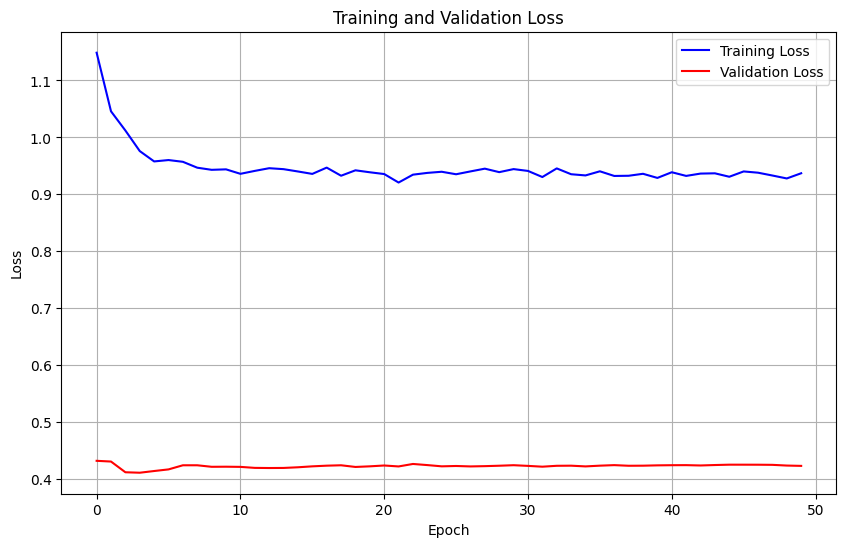

Final LSTM Metrics:
MSE: 6.342039e-05
RMSE: 0.007963692
MAE: 0.0049834438


/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning

In [12]:
GDP_model_lstm, GDP_predictions_lstm, GDP_lstm_metrics, GDP_scaler_X, GDP_scaler_y = lstm.train_lstm_model(lstm_df, inputs, ['log_GDP'], learning_rate = 0.0009, num_epochs= 50)
GDP_var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, LAGS, 'log_GDP')
GDP_no_outlier_var_metrics = var.get_test_errors(excluding_outliers, train_dt_var, test_dt_var, LAGS, 'log_GDP')
GDP_pvar_metrics= pvar.get_test_errors(lstm_df, lstm_test, LAGS, 'log_GDP', panel_var_coef)



## Get Metrics for Household Debt

In [13]:
hhd_model_lstm, hhd_predictions_lstm, hhd_lstm_metrics, hhd_scaler_X, hhd_scaler_y = lstm.train_lstm_model(lstm_df, inputs, ['household_debt'], .003, num_epochs= 200)
hhd_var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, LAGS, 'household_debt')
hhd_no_outlier_var_metrics = var.get_test_errors(excluding_outliers, train_dt_var, test_dt_var, LAGS, 'household_debt')
hhd_pvar_metrics= pvar.get_test_errors(lstm_df, lstm_test, LAGS, 'household_debt', panel_var_coef)


Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/200], Train Loss: 0.7617, Val Loss: 0.4288
Epoch [20/200], Train Loss: 0.7418, Val Loss: 0.4189
Epoch [30/200], Train Loss: 0.7412, Val Loss: 0.4216
Epoch [40/200], Train Loss: 0.7371, Val Loss: 0.4318
Epoch [50/200], Train Loss: 0.7392, Val Loss: 0.4244
Epoch [60/200], Train Loss: 0.7295, Val Loss: 0.4256
Epoch [70/200], Train Loss: 0.7492, Val Loss: 0.4327
Epoch [80/200], Train Loss: 0.7437, Val Loss: 0.4261
Epoch [90/200], Train Loss: 0.7532, Val Loss: 0.4276
Epoch [100/200], Train Loss: 0.7291, Val Loss: 0.4224
Epoch [110/200], Train Loss: 0.7401, Val Loss: 0.4210


KeyboardInterrupt: 

## Get Metrics for Private Debt

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/100], Train Loss: 0.9261, Val Loss: 0.6456
Epoch [20/100], Train Loss: 0.8840, Val Loss: 0.6482
Epoch [30/100], Train Loss: 0.8884, Val Loss: 0.6495
Epoch [40/100], Train Loss: 0.8959, Val Loss: 0.6505
Epoch [50/100], Train Loss: 0.8648, Val Loss: 0.6518
Epoch [60/100], Train Loss: 0.8905, Val Loss: 0.6495
Epoch [70/100], Train Loss: 0.8754, Val Loss: 0.6478
Epoch [80/100], Train Loss: 0.8893, Val Loss: 0.6493
Epoch [90/100], Train Loss: 0.8681, Val Loss: 0.6524
Epoch [100/100], Train Loss: 0.8723, Val Loss: 0.6511


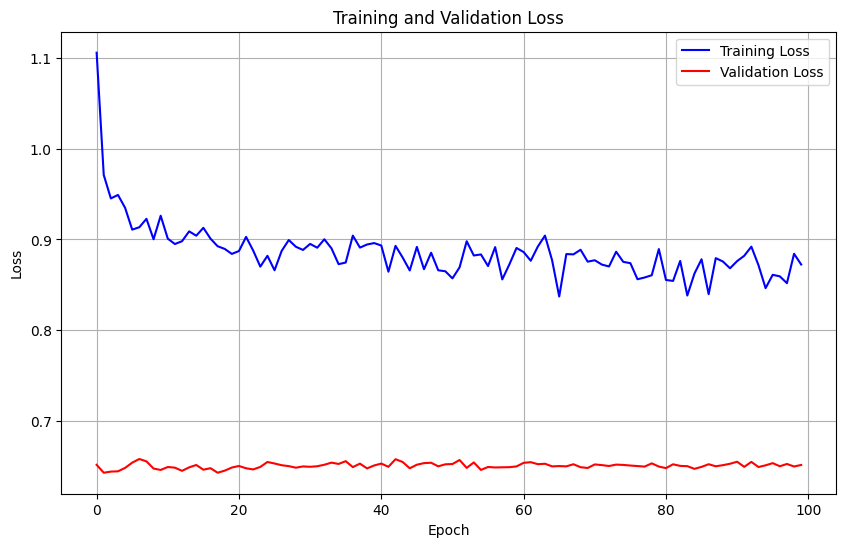

Final LSTM Metrics:
MSE: 6.661595
RMSE: 2.5810065
MAE: 1.5235175


/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning

In [13]:
fd_model_lstm, fd_predictions_lstm, fd_lstm_metrics, fd_scaler_X, fd_scaler_y = lstm.train_lstm_model(lstm_df, inputs, ['private_debt'], .003, num_epochs= 100)
fd_var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, LAGS, 'private_debt')
fd_no_outlier_var_metrics  = var.get_test_errors(excluding_outliers, train_dt_var, test_dt_var, LAGS, 'private_debt')
fd_pvar_metrics= pvar.get_test_errors(lstm_df, lstm_test, LAGS, 'private_debt', panel_var_coef)



In [14]:
# pr_model_lstm, pr_predictions_lstm, pr_mse, pr_rmse, pr_mae, pr_scaler_X, pr_scaler_y= train_lstm_model(all_lstm_data, inputs, ['policy_rate'], .002, num_epochs= 200)


Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.9063, Val Loss: 0.4117
Epoch [20/50], Train Loss: 0.8862, Val Loss: 0.4104
Epoch [30/50], Train Loss: 0.8799, Val Loss: 0.4102
Epoch [40/50], Train Loss: 0.8793, Val Loss: 0.4105
Epoch [50/50], Train Loss: 0.8779, Val Loss: 0.4093


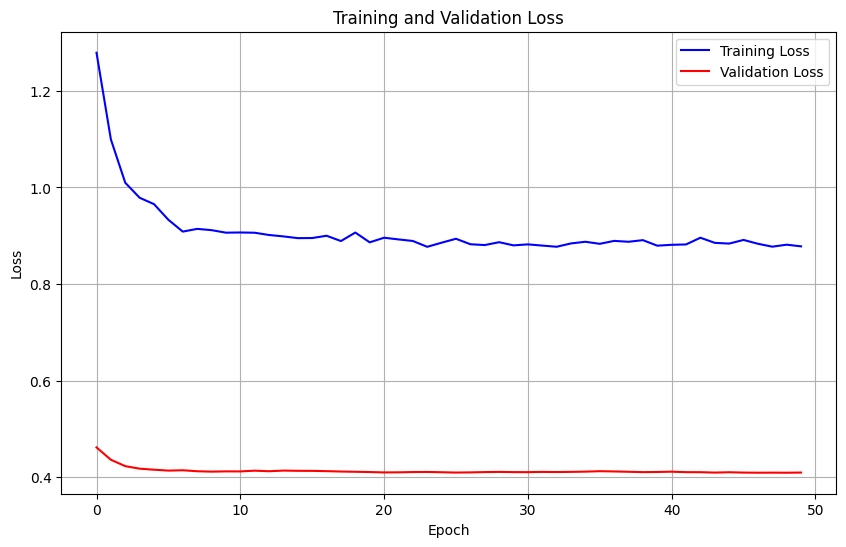

Seed set to 18
Seed set to 18


Final LSTM Metrics:
MSE: 6.1106926e-05
RMSE: 0.007817092
MAE: 0.0048395777


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.6872, Val Loss: 0.3628
Epoch [20/50], Train Loss: 0.6777, Val Loss: 0.3609
Epoch [30/50], Train Loss: 0.6543, Val Loss: 0.3707
Epoch [40/50], Train Loss: 0.6545, Val Loss: 0.3607
Epoch [50/50], Train Loss: 0.6593, Val Loss: 0.3595


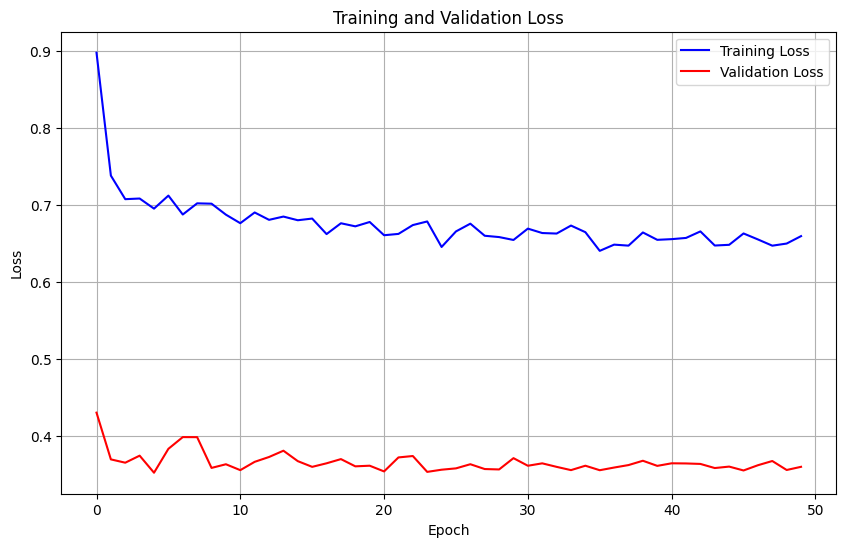

Seed set to 18
Seed set to 18


Final LSTM Metrics:
MSE: 0.26529258
RMSE: 0.5150656
MAE: 0.37449178


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.9261, Val Loss: 0.6456
Epoch [20/50], Train Loss: 0.8840, Val Loss: 0.6482
Epoch [30/50], Train Loss: 0.8884, Val Loss: 0.6495
Epoch [40/50], Train Loss: 0.8959, Val Loss: 0.6505
Epoch [50/50], Train Loss: 0.8648, Val Loss: 0.6518


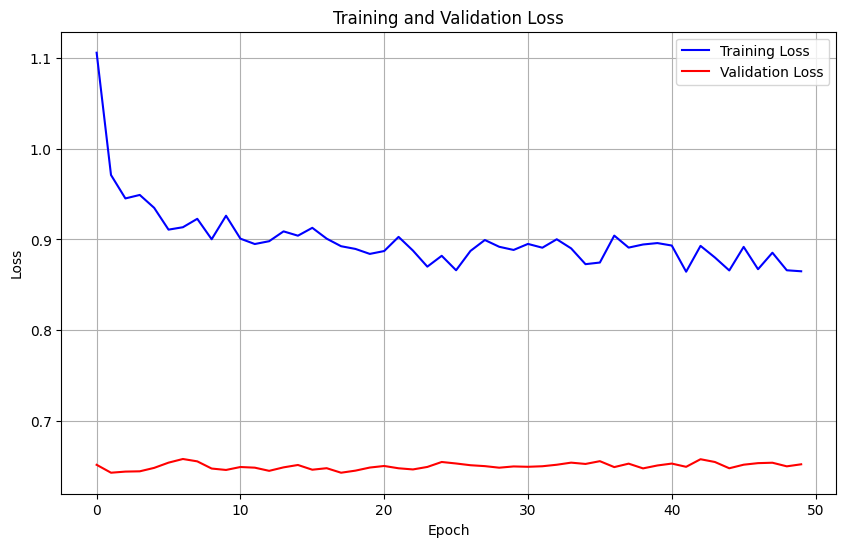

Final LSTM Metrics:
MSE: 6.6672287
RMSE: 2.5820978
MAE: 1.5175639


In [15]:
variables = final_detrend.columns
model_scaler_dict = deepvar.get_model_and_scaler(lstm_df, variables, inputs, param_dict)

In [16]:
inputsvar = final_detrend.columns
gdp_deepvar_metrics = deepvar.test_errors(lstm_df, lstm_test, 'log_GDP', model_scaler_dict, inputsvar)
hhd_deepvar_metrics = deepvar.test_errors(lstm_df, lstm_test, 'household_debt', model_scaler_dict, inputsvar)
fd_deepvar_metrics = deepvar.test_errors(lstm_df, lstm_test, 'private_debt', model_scaler_dict,inputsvar)

Seed set to 18
Seed set to 18
Seed set to 18


Index(['log_GDP', 'household_debt', 'private_debt'], dtype='object')


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

In [17]:
gdp_latex_comparison_table = hp.create_model_comparison_latex_table(gdp_deepvar_metrics, GDP_var_metrics, GDP_no_outlier_var_metrics, GDP_pvar_metrics)
print(gdp_latex_comparison_table)

hhd_latex_comparison_table = hp.create_model_comparison_latex_table(hhd_deepvar_metrics, hhd_var_metrics, hhd_no_outlier_var_metrics, hhd_pvar_metrics)
print(hhd_latex_comparison_table)

fd_latex_comparison_table = hp.create_model_comparison_latex_table(fd_deepvar_metrics, fd_var_metrics, fd_no_outlier_var_metrics, fd_pvar_metrics)
print(fd_latex_comparison_table)


\begin{table}[htbp]
\centering
\caption{Model Performance Comparison}
\renewcommand{\arraystretch}{1.2}
\begin{tabularx}{\textwidth}{
    >{\raggedright\arraybackslash}X 
    >{\centering\arraybackslash}X 
    >{\centering\arraybackslash}X 
    >{\centering\arraybackslash}X 
    >{\centering\arraybackslash}X 
}
\hline
\textbf{Metric} & \textbf{DeepVAR} & \textbf{VAR} & \textbf{VAR (Excluding Growth Outliers)} & \textbf{Panel VAR} \\
\hline
Mean Squared Error (MSE) & 0.000063 & 0.000069 & 0.000069 & 0.000100 \\
Root Mean Squared Error (RMSE) & 0.007953 & 0.008324 & 0.008322 & 0.009984 \\
Mean Absolute Error (MAE) & 0.004984 & 0.005245 & 0.005214 & 0.007586 \\
\hline
\end{tabularx}
\end{table}
\begin{table}[htbp]
\centering
\caption{Model Performance Comparison}
\renewcommand{\arraystretch}{1.2}
\begin{tabularx}{\textwidth}{
    >{\raggedright\arraybackslash}X 
    >{\centering\arraybackslash}X 
    >{\centering\arraybackslash}X 
    >{\centering\arraybackslash}X 
    >{\centering\arrayb

In [18]:
def calculate_percent_improvement(deepvar_metrics, compare_metrics):
    improvements = {}
    
    # Define the metric names for clarity (order should match the input lists)
    metric_names = ['total_mse', 'rmse', 'total_mae']
    
    for i, metric in enumerate(metric_names):
        # Get the values for DeepVAR and the comparison model
        deepvar_value = deepvar_metrics[i]
        compare_value = compare_metrics[i]
        
        if compare_value != 0:  
            improvement = ((compare_value - deepvar_value) / compare_value) * 100
            improvements[metric] = improvement
        else:
            improvements[metric] = None  
    
    return improvements

improvement_deepvar_vs_var_gdp = calculate_percent_improvement(gdp_deepvar_metrics, GDP_var_metrics)
print("GDP model improvement",improvement_deepvar_vs_var_gdp)


improvement_deepvar_vs_var_hhd = calculate_percent_improvement(hhd_deepvar_metrics, hhd_var_metrics)
print("household debt model improvement",improvement_deepvar_vs_var_hhd)

improvement_deepvar_vs_var_pd = calculate_percent_improvement(fd_deepvar_metrics, fd_var_metrics)
print("private debt model improvement",improvement_deepvar_vs_var_pd)

GDP model improvement {'total_mse': 8.705606247872943, 'rmse': 4.4519002009317585, 'total_mae': 4.96944266743096}
household debt model improvement {'total_mse': 18.481236845603476, 'rmse': 9.71225822161873, 'total_mae': 4.68798943971693}
private debt model improvement {'total_mse': 29.052377609433854, 'rmse': 15.7695883955408, 'total_mae': 8.10487272060534}


In [19]:
plot_data = lstm_test.reset_index().drop(columns = {"Country","TIME_PERIOD"})
plot_data = plot_data['log_GDP']

# hp.visualize_model_performance(plot_data, GDP_predictions_lstm)

# GDP_predictions_lstm_df = pd.DataFrame(GDP_predictions_lstm, columns=["log_GDP"])
# GDP_predictions_lstm_df = GDP_predictions_lstm_df.set_index(lstm_test.index)

# GDP_predictions_lstm
lstm_test


log_GDP  household_debt  private_debt  log_GDP_lag1  \
Country  TIME_PERIOD                                                         
Colombia 2017-03-31   0.000451           0.063        -0.792      0.005816   
         2017-06-30   0.004779           0.444        -0.356      0.000451   
         2017-09-30   0.004386           0.010        -0.812      0.004779   
         2017-12-31   0.004816           0.193        -0.578      0.004386   
         2018-03-31   0.006612           0.040        -0.408      0.004816   
...                        ...             ...           ...           ...   
Belgium  2018-12-31   0.009724           0.300         0.900      0.003900   
         2019-03-31   0.002609           0.400        -0.200      0.009724   
         2019-06-30   0.005386           0.300        -0.900      0.002609   
         2019-09-30   0.007315           0.000         2.300      0.005386   
         2019-12-31   0.005931           0.700        -1.400      0.007315   

                      log_GDP_lag2  log_GDP_lag3  household_debt_lag1  \
Country  TIME_PERIOD                                                    
Colombia 2017-03-31       0.003739     -0.000674               -0.302   
         2017-06-30       0.005816      0.003739                0.063   
         2017-09-30       0.000451      0.005816                0.444   
         2017-12-31       0.004779      0.000451                0.010   
         2018-03-31       0.004386      0.004779                0.193   
...                            ...           ...                  ...   
Belgium  2018-12-31       0.004515      0.003720               -0.100   
         2019-03-31       0.003900      0.004515                0.300   
         2019-06-30       0.009724      0.003900                0.400   
         2019-09-30       0.002609      0.009724                0.300   
         2019-12-31       0.005386      0.002609                0.000   

                      household_debt_lag2  household_debt_lag3  \
Country  TIME_PERIOD                                             
Colombia 2017-03-31                -0.070               -0.068   
         2017-06-30                -0.302               -0.070   
         2017-09-30                 0.063               -0.302   
         2017-12-31                 0.444                0.063   
         2018-03-31                 0.010                0.444   
...                                   ...                  ...   
Belgium  2018-12-31                 0.400               -0.300   
         2019-03-31                -0.100                0.400   
         2019-06-30                 0.300               -0.100   
         2019-09-30                 0.400                0.300   
         2019-12-31                 0.300                0.400   

                      private_debt_lag1  private_debt_lag2  private_debt_lag3  
Country  TIME_PERIOD                                                           
Colombia 2017-03-31              -0.938             -0.670             -0.753  
         2017-06-30              -0.792             -0.938             -0.670  
         2017-09-30              -0.356             -0.792             -0.938  
         2017-12-31              -0.812             -0.356             -0.792  
         2018-03-31              -0.578             -0.812             -0.356  
...                                 ...                ...                ...  
Belgium  2018-12-31              -3.400              0.300             -3.000  
         2019-03-31               0.900             -3.400              0.300  
         2019-06-30              -0.200              0.900             -3.400  
         2019-09-30              -0.900             -0.200              0.900  
         2019-12-31               2.300             -0.900             -0.200  

[826 rows x 12 columns]

In [20]:
lstm_test_data = hp.get_test_data(lstm_df)

deepvar.test_errors(lstm_df, lstm_test, 'log_GDP', model_scaler_dict, inputsvar)


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18


[6.325235505543617e-05, 0.007953134919981942, 0.004984003878011661]

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


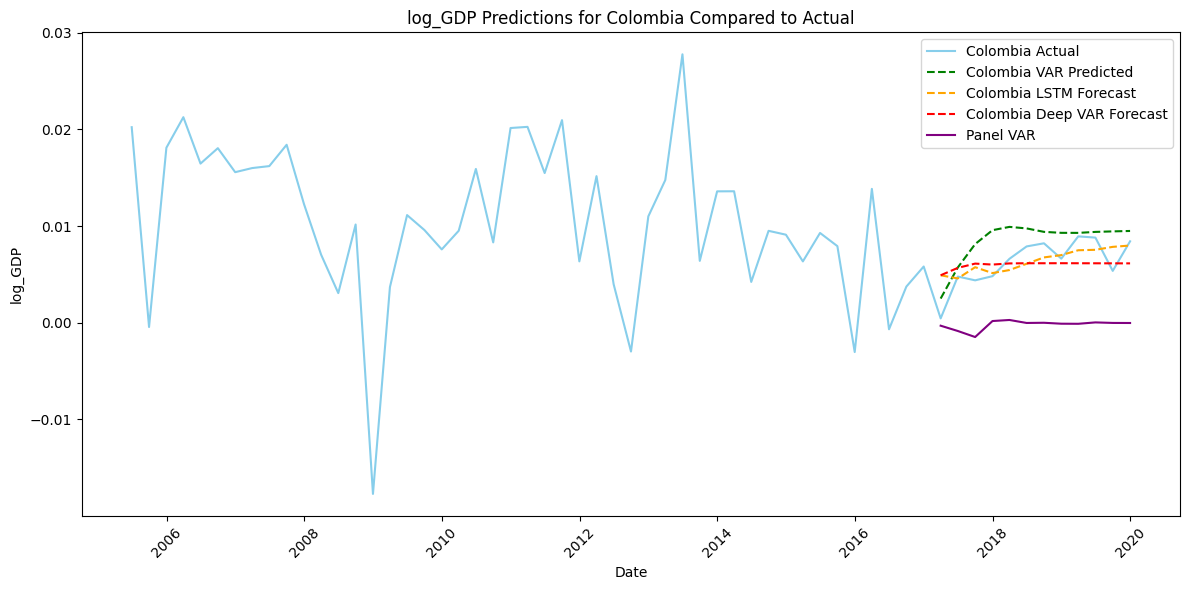

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


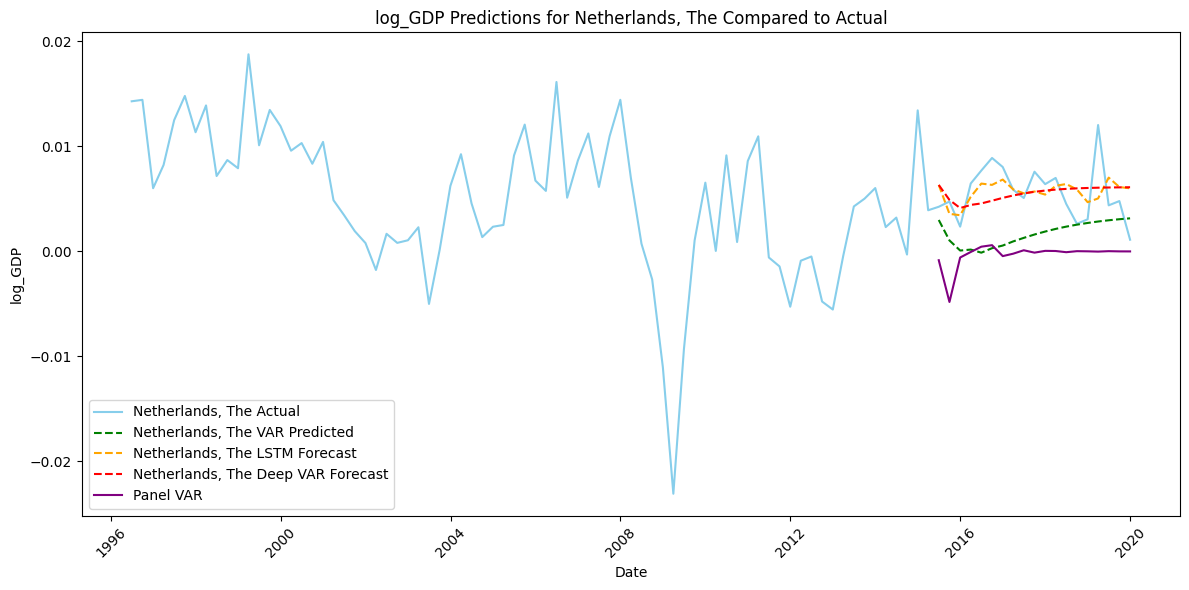

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


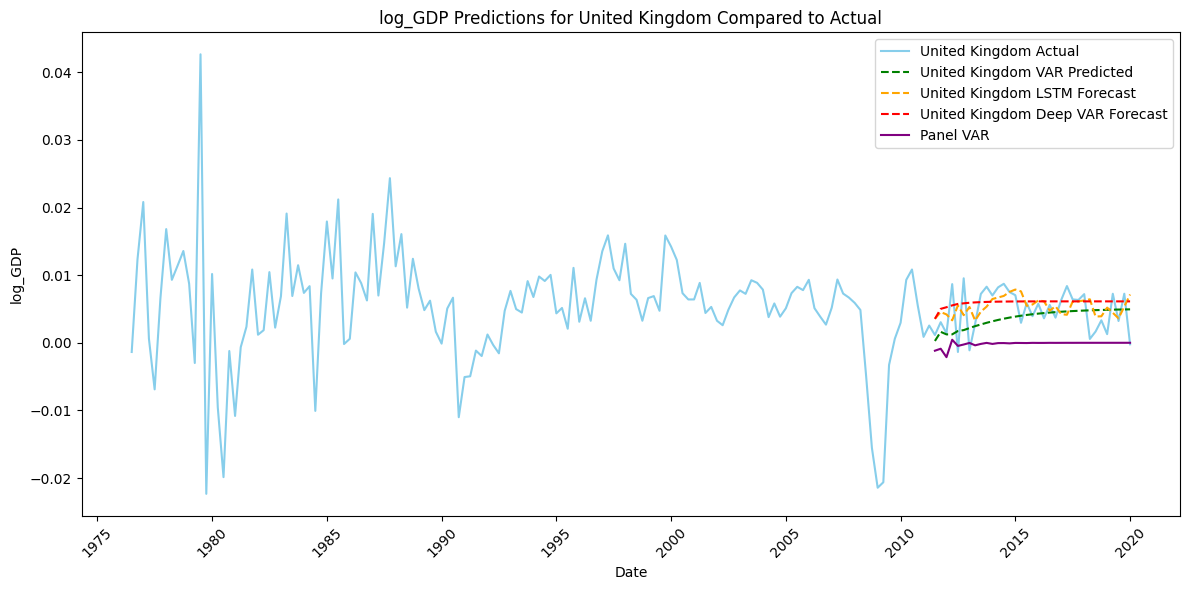

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


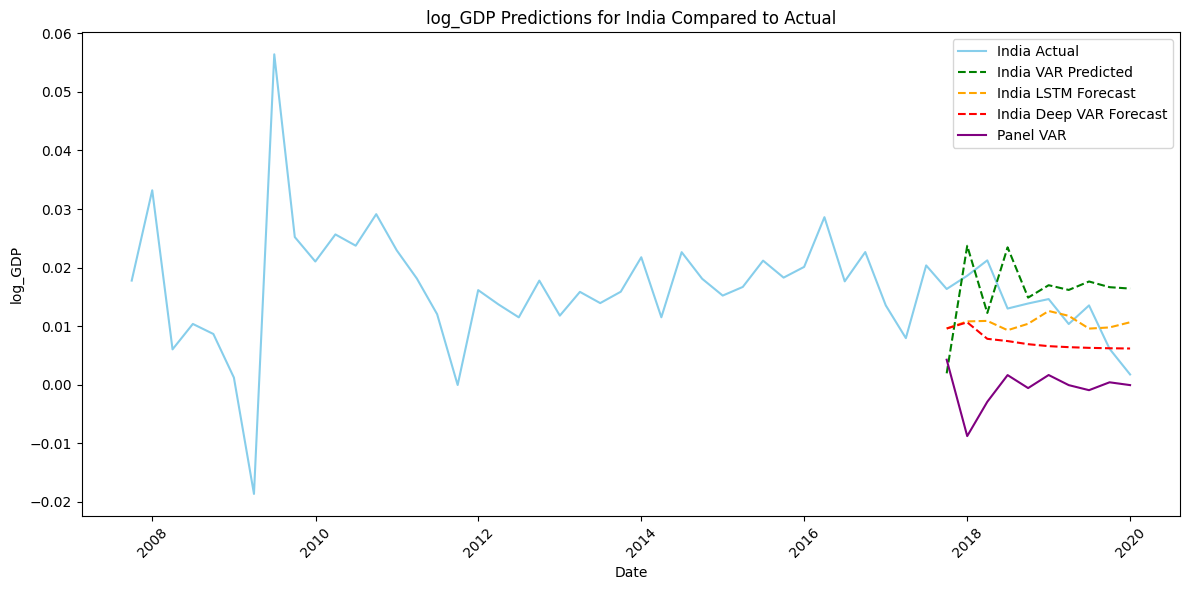

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


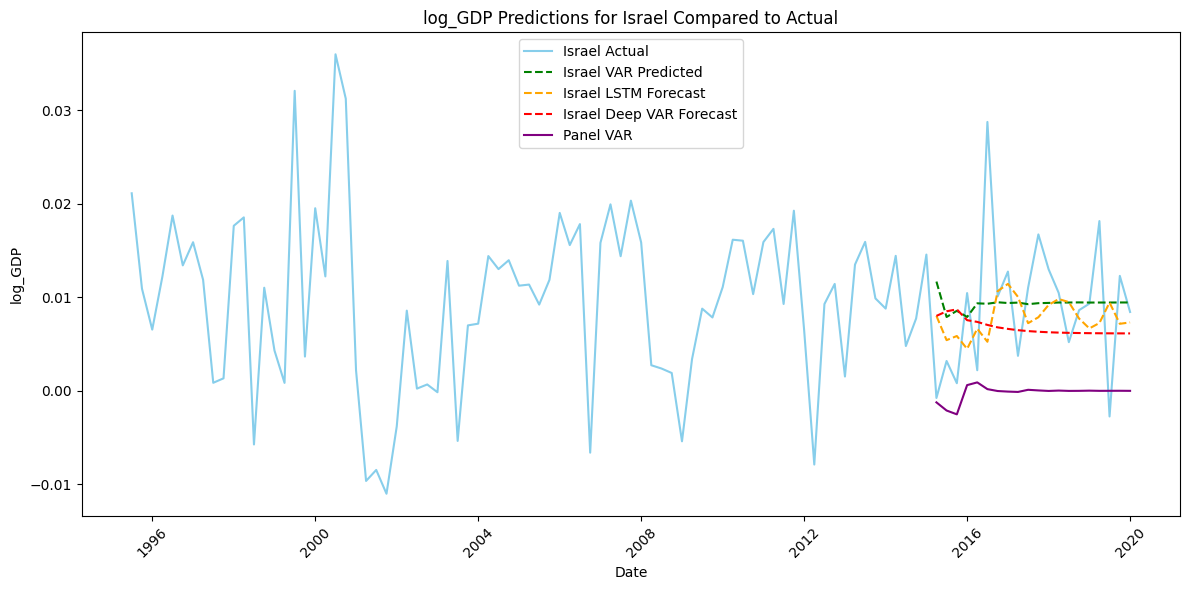

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


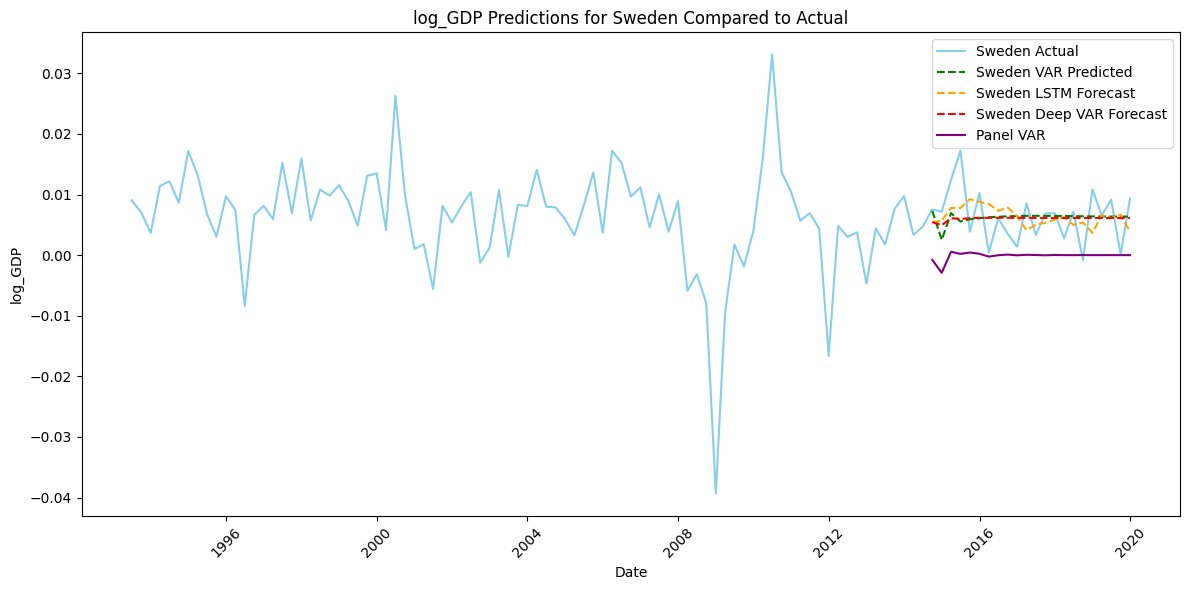

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


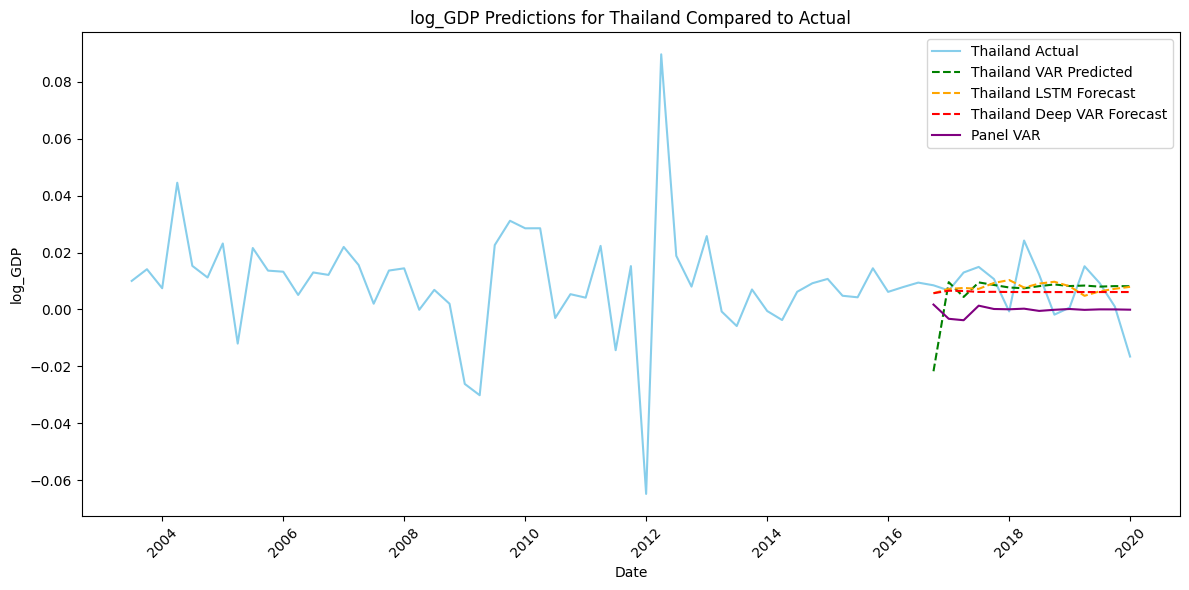

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


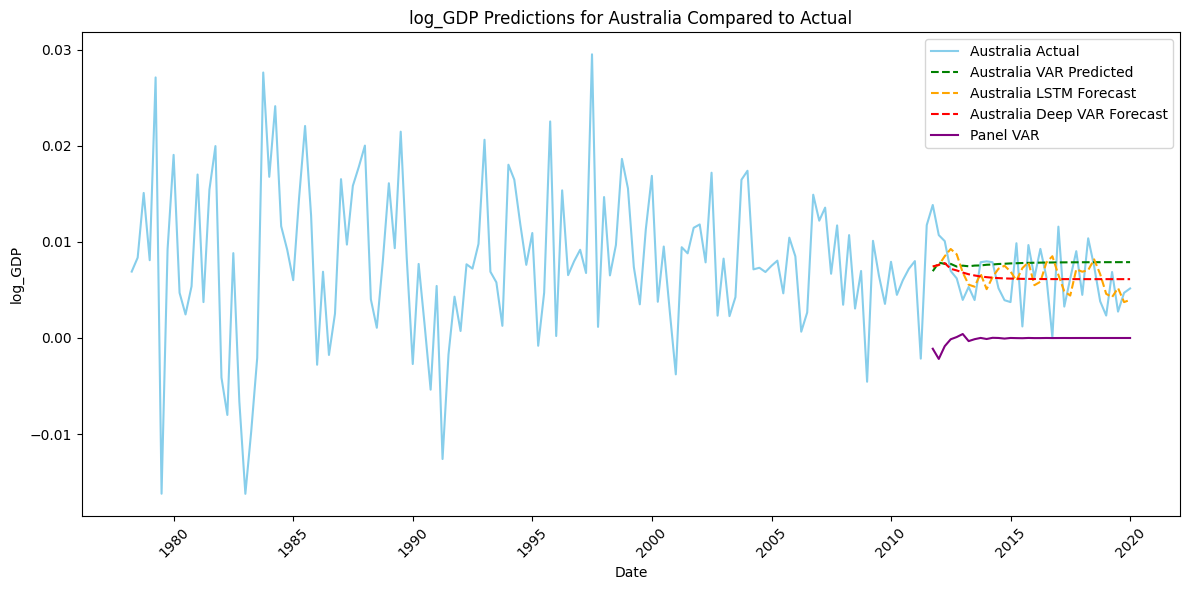

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


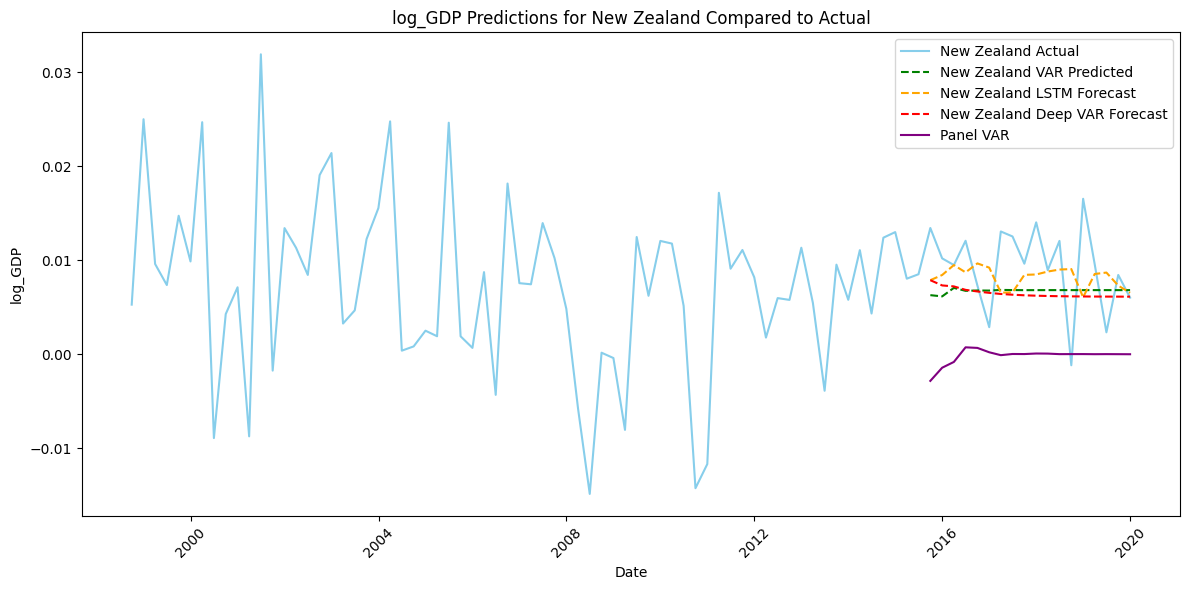

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


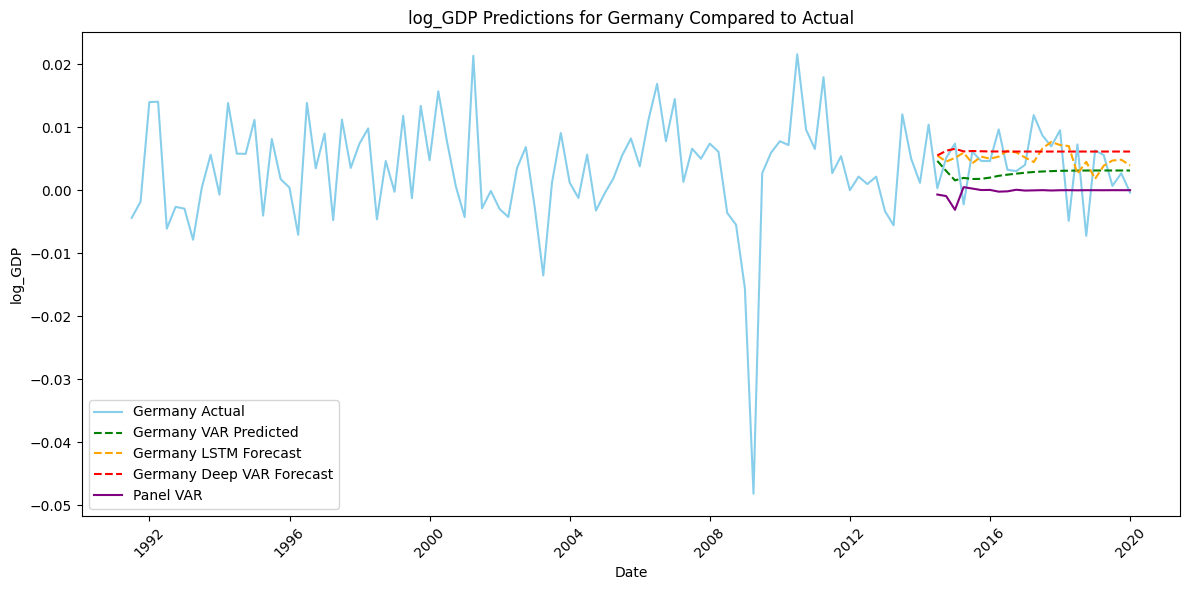

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


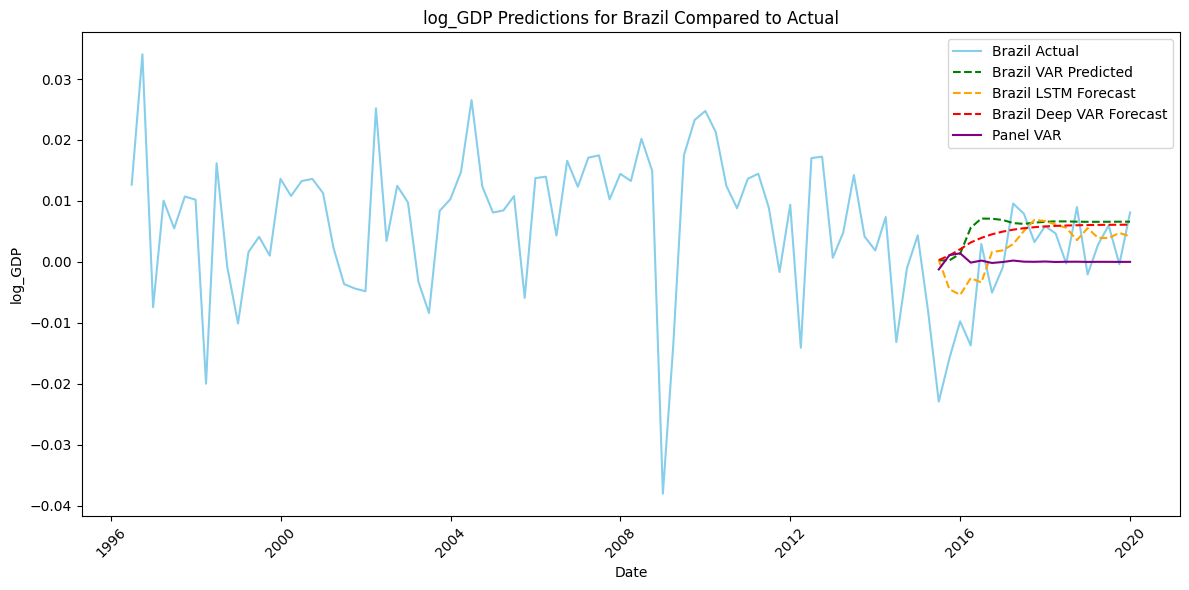

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


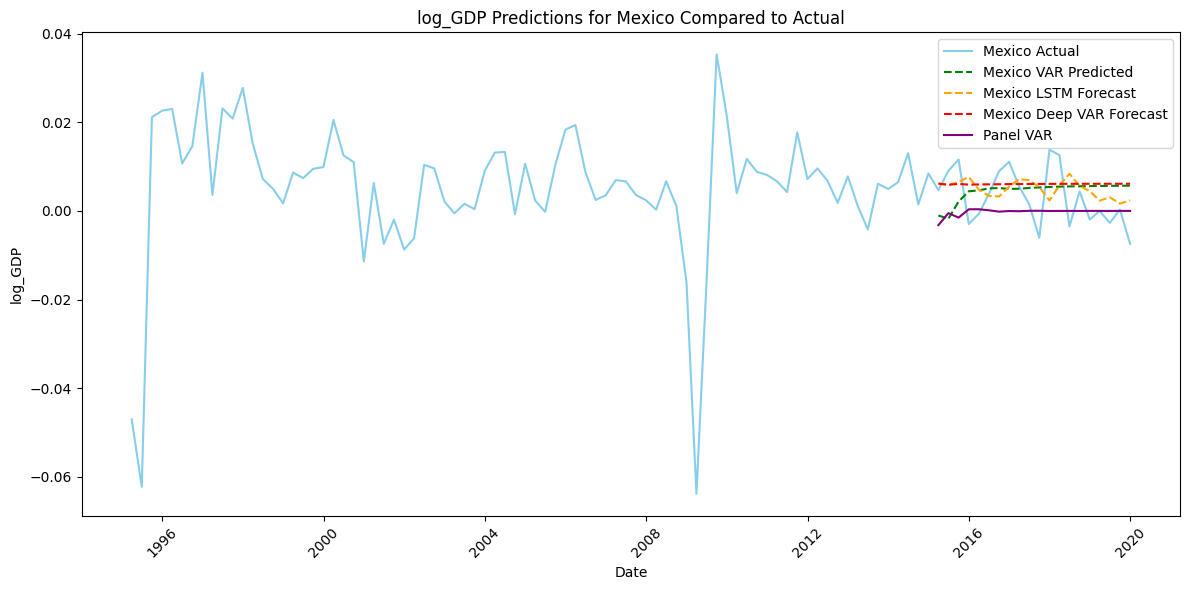

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


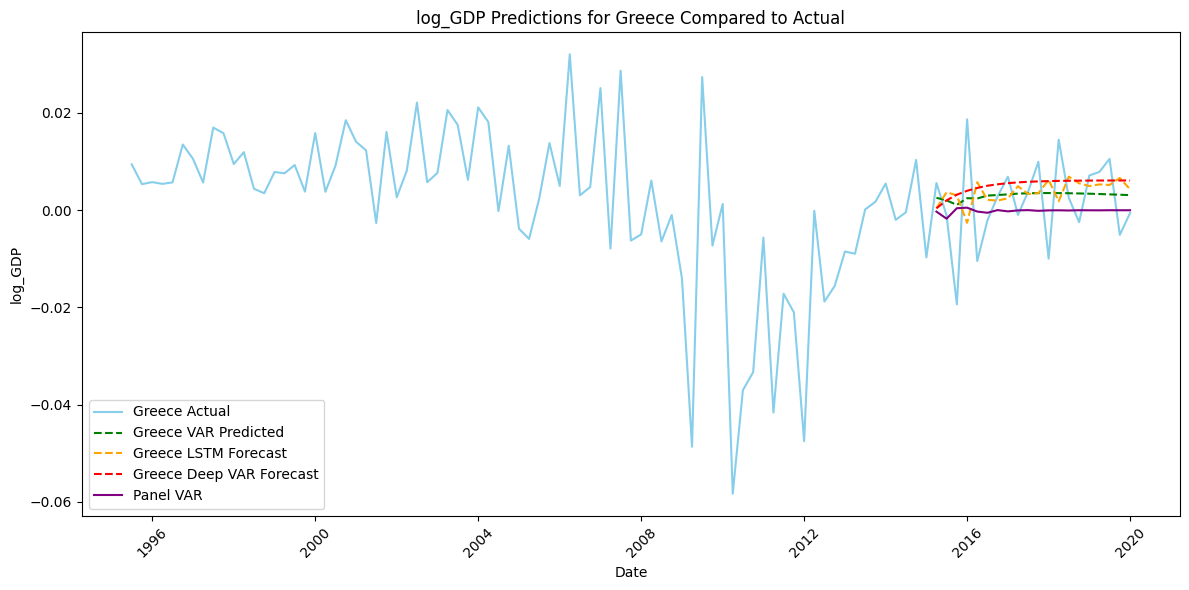

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


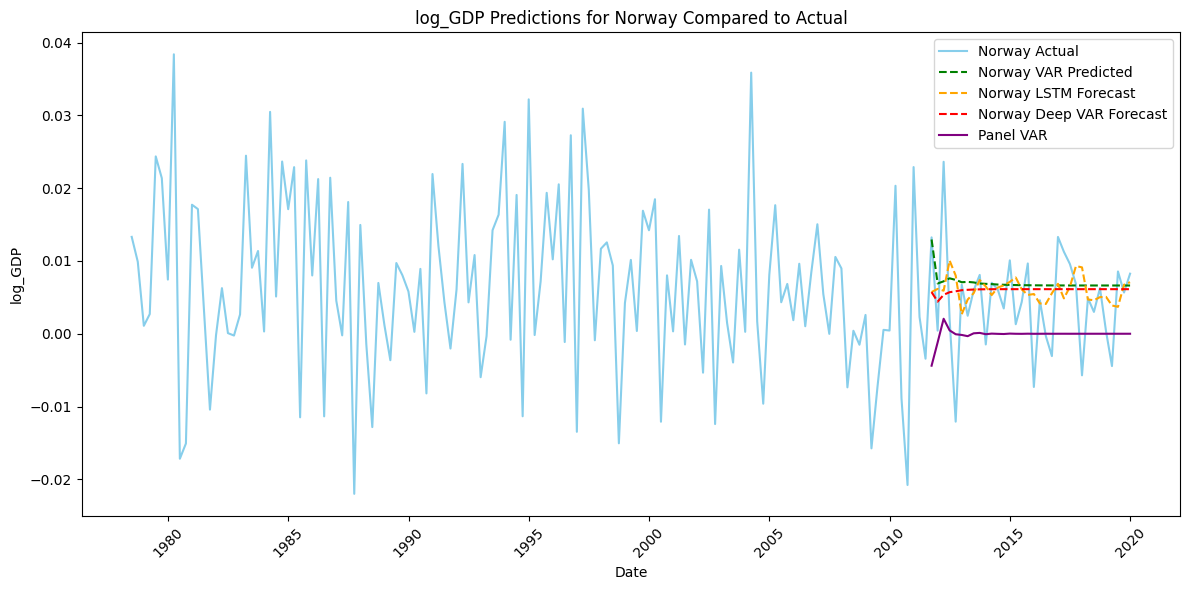

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


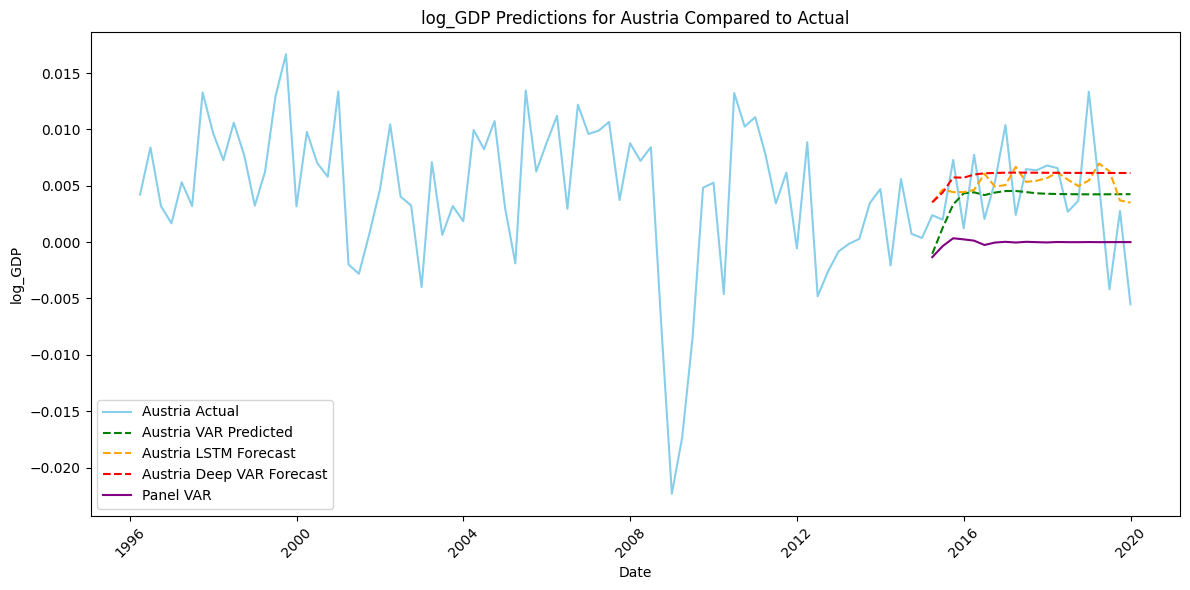

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


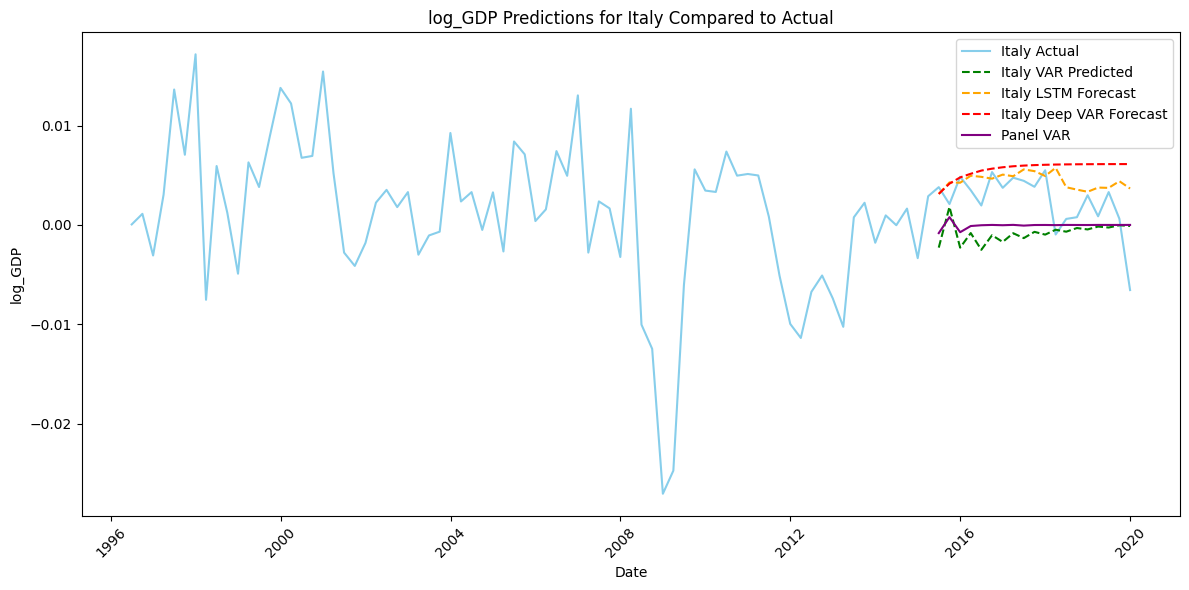

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


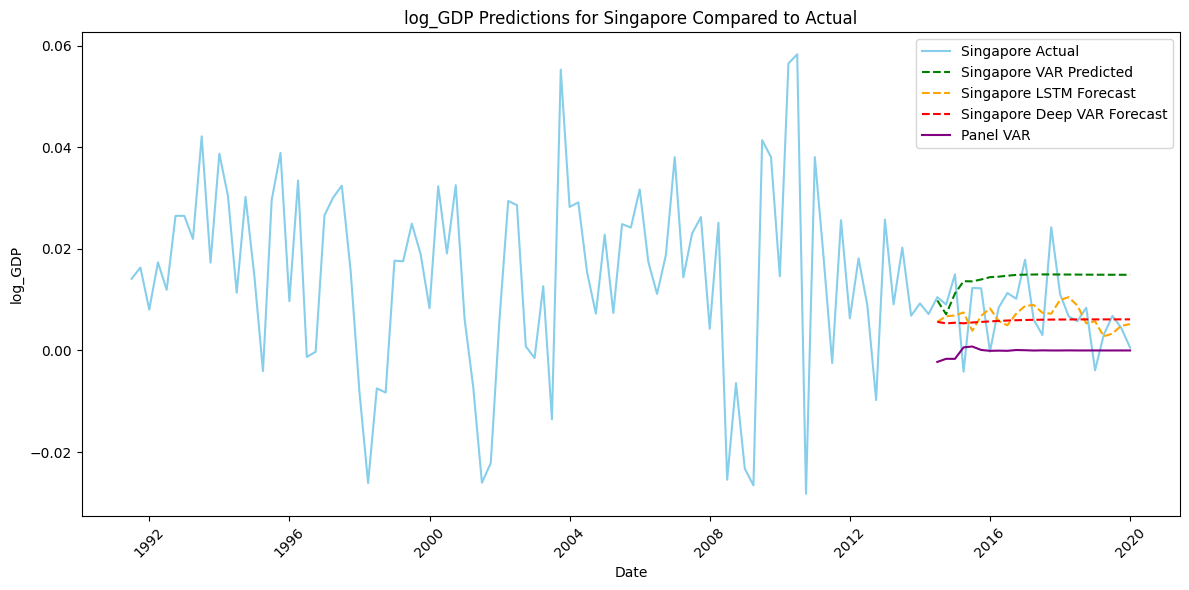

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


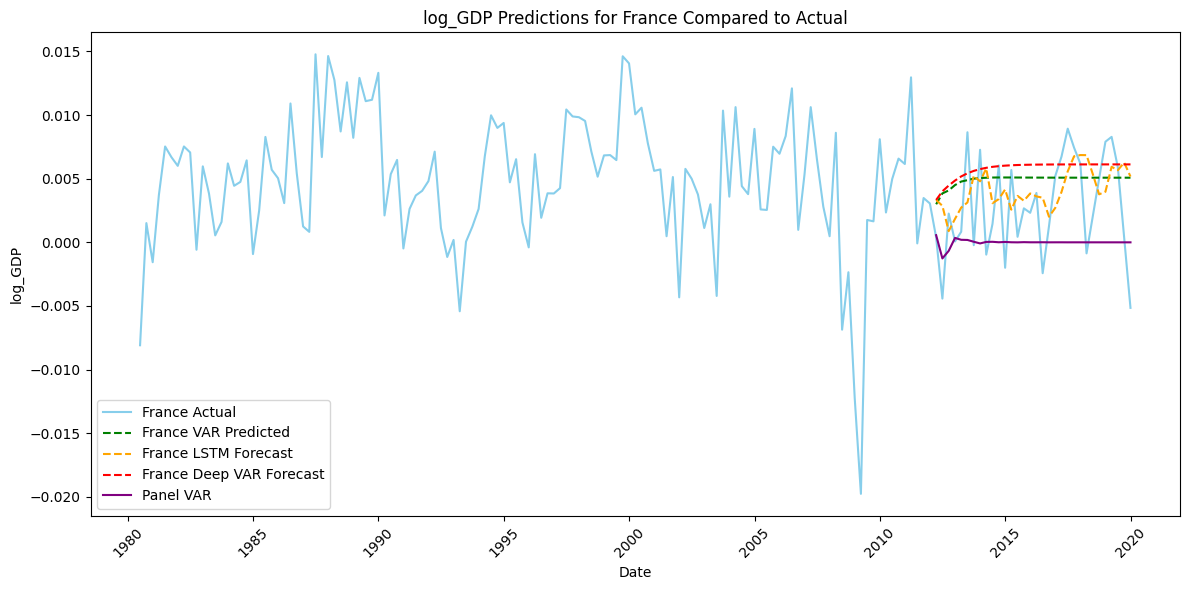

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


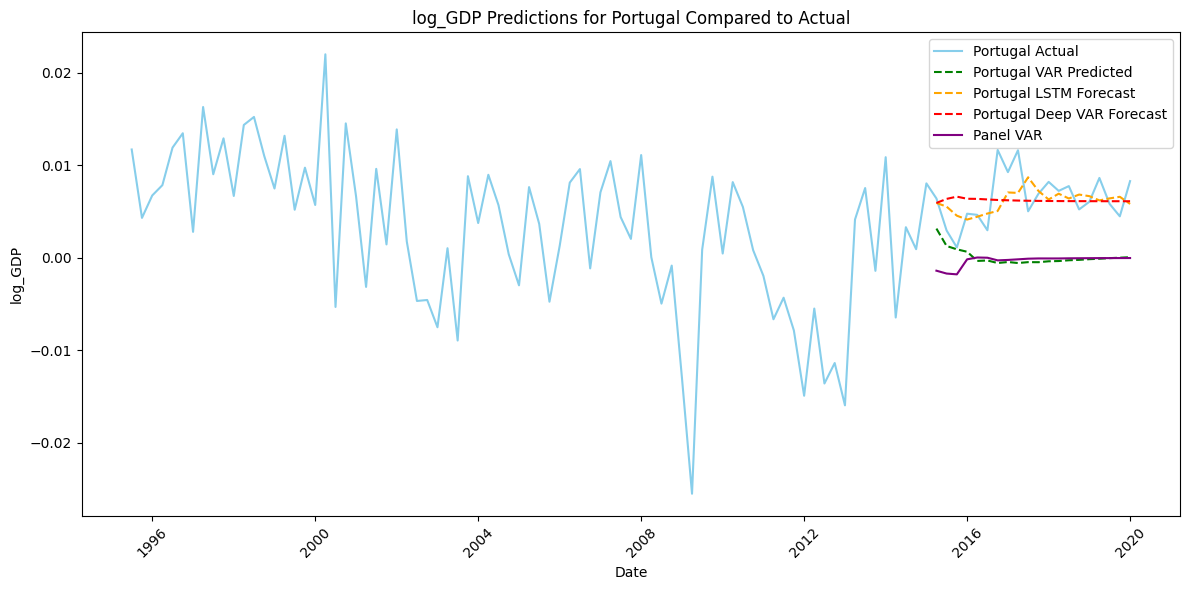

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


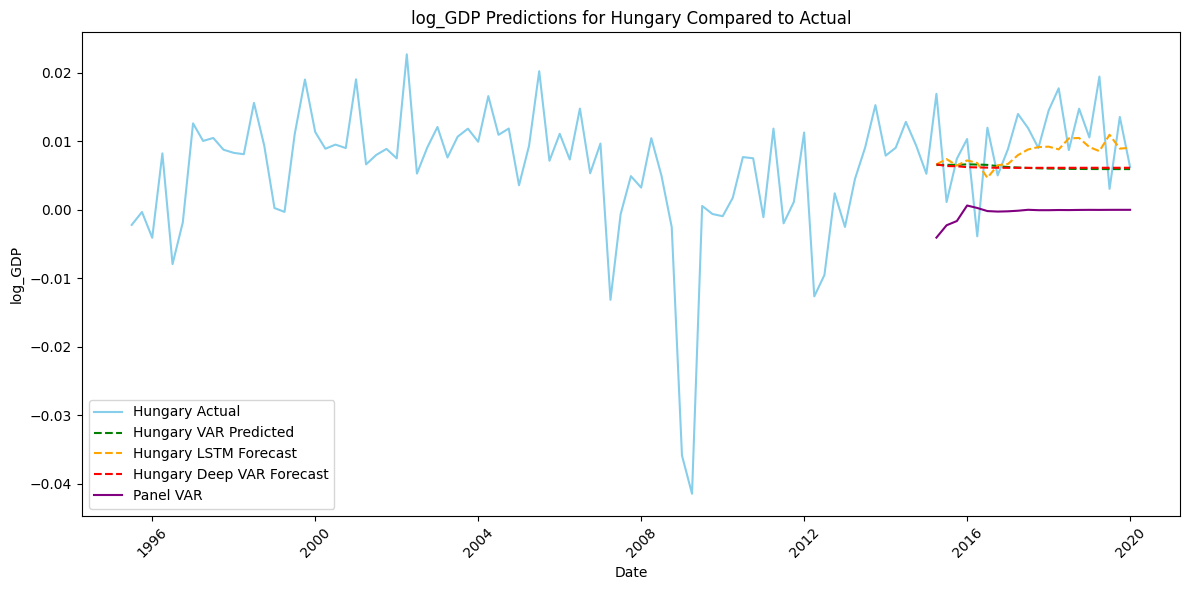

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


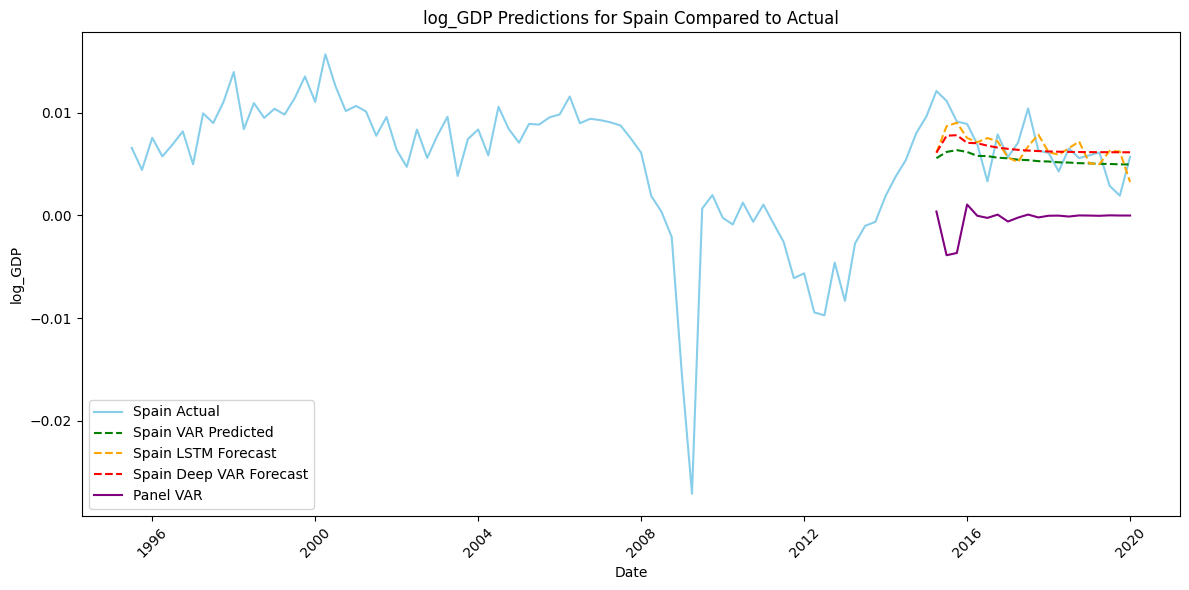

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


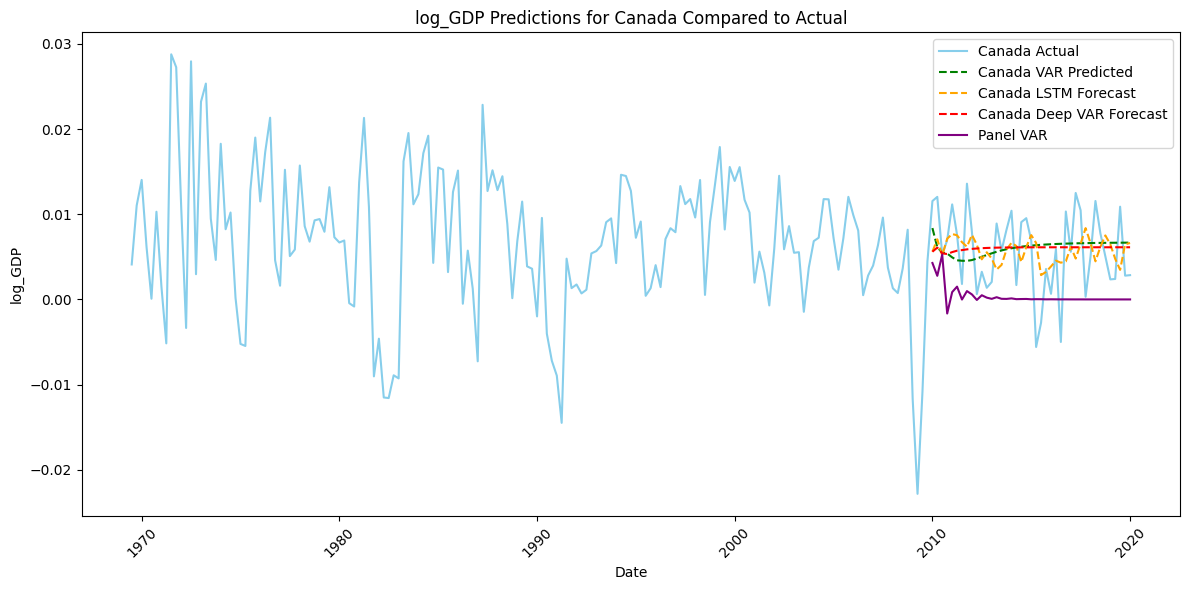

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


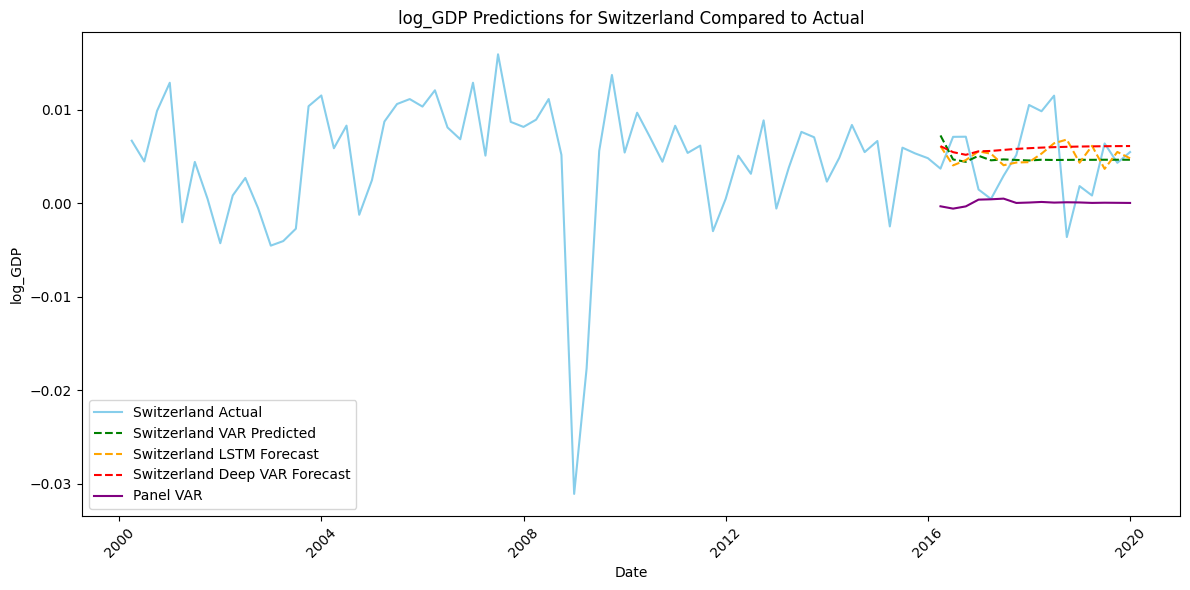

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


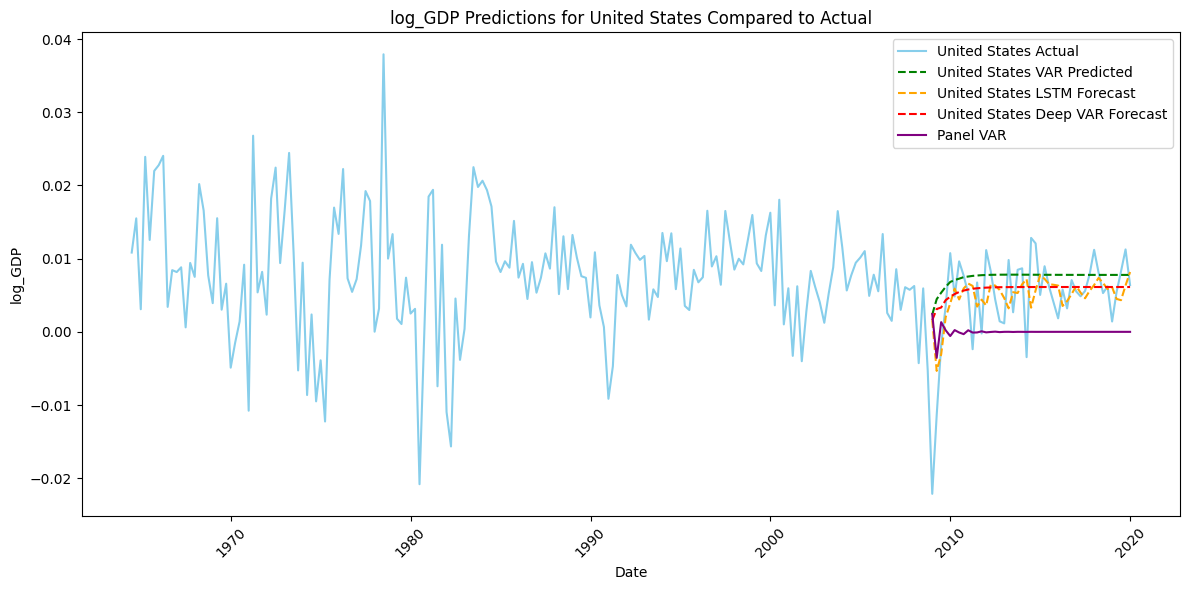

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


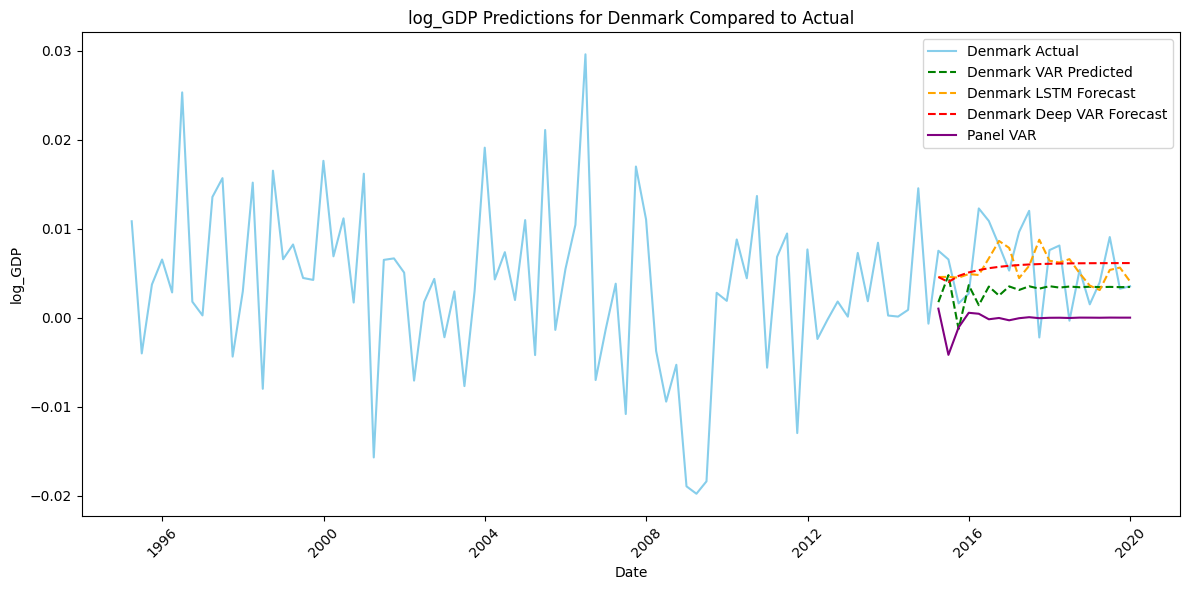

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


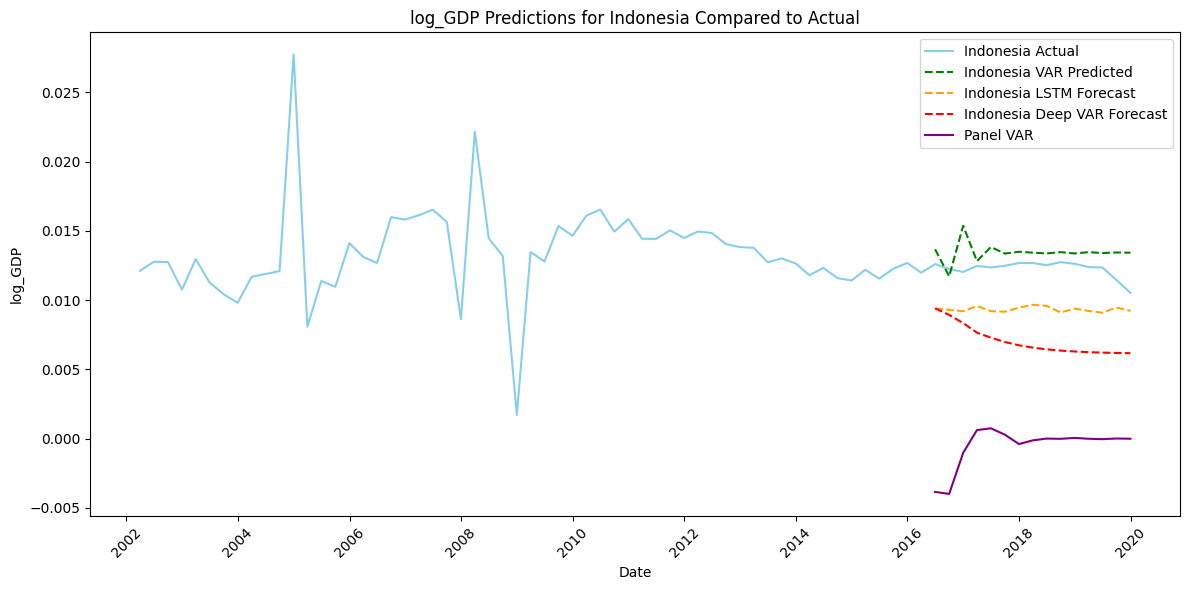

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


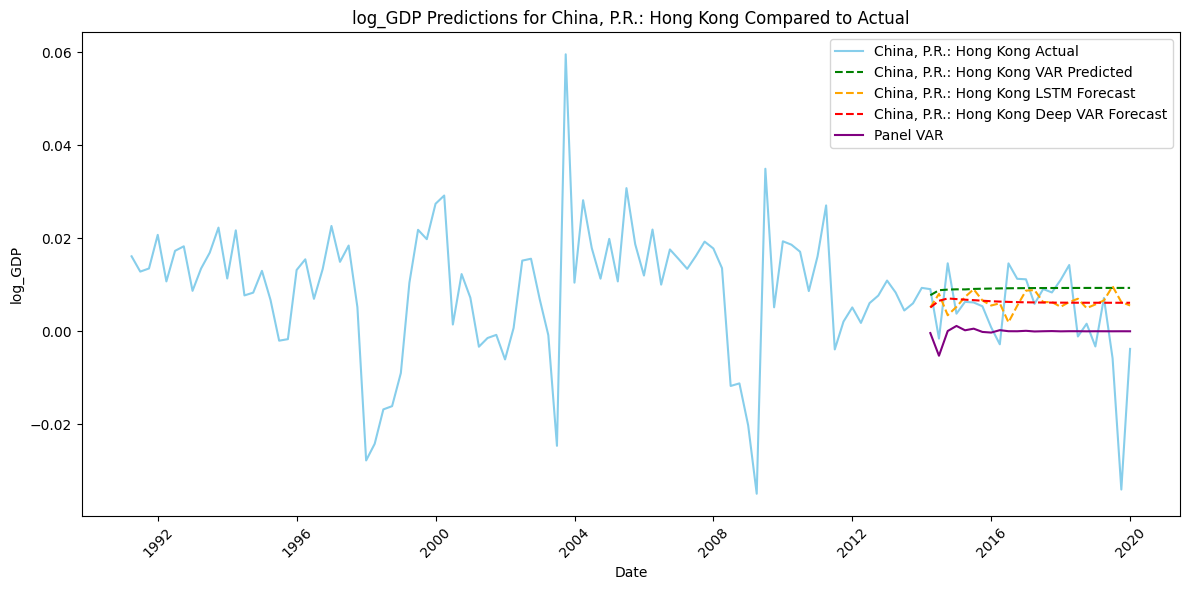

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


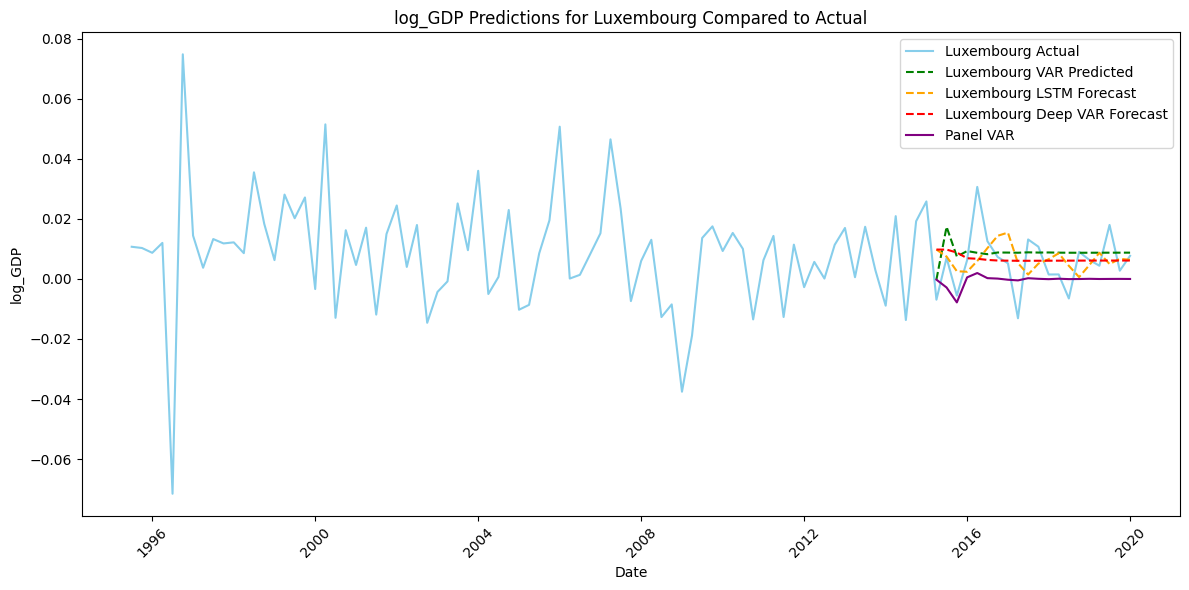

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


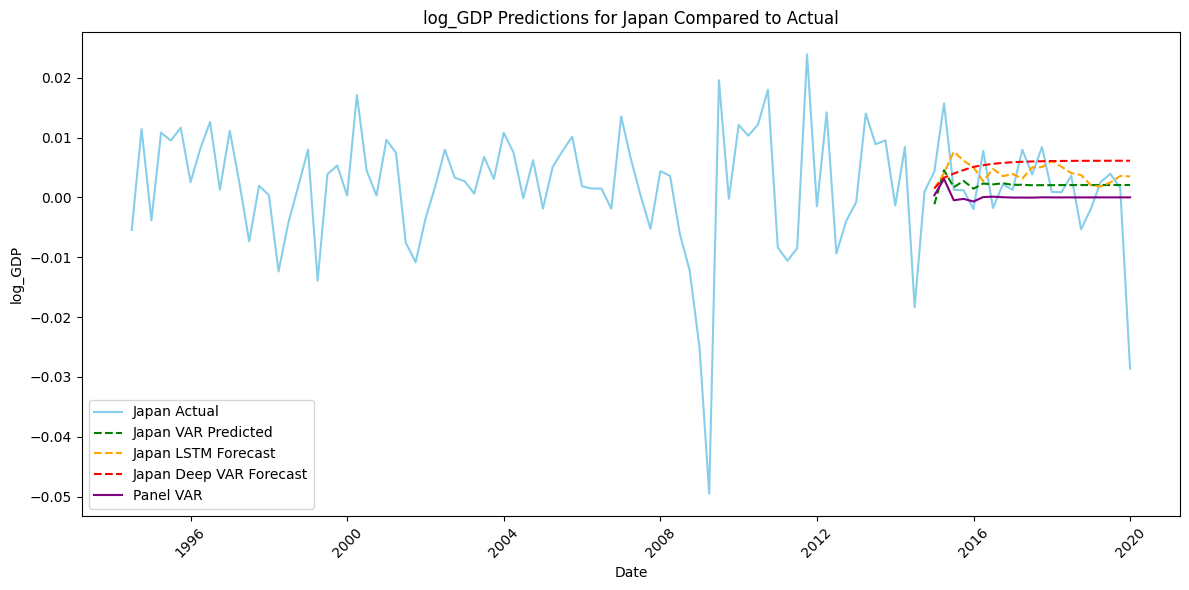

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


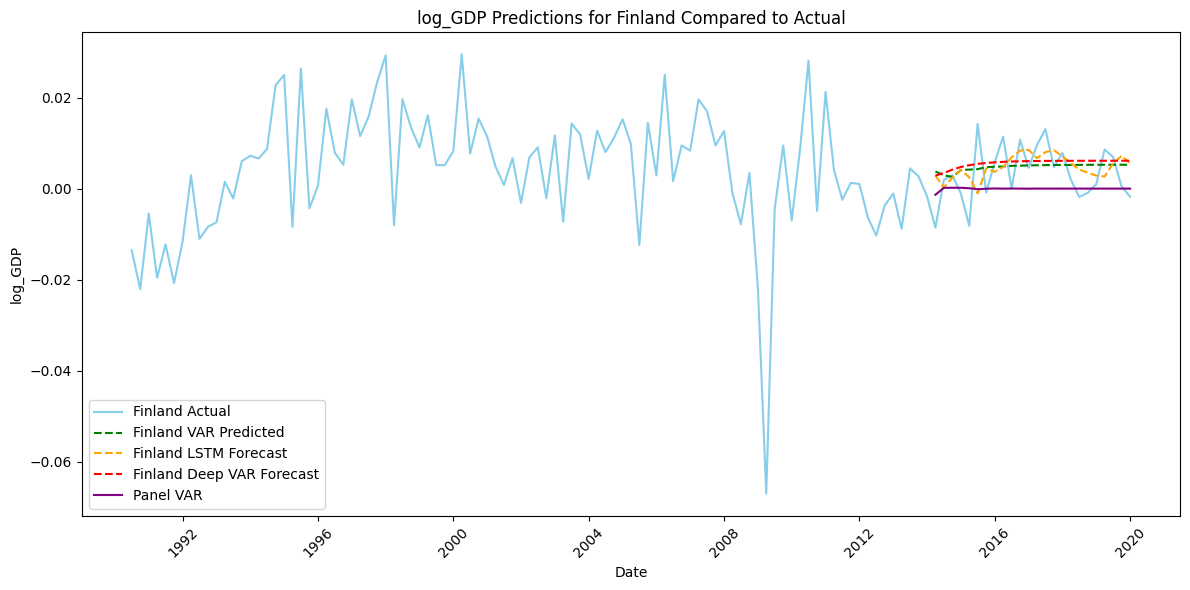

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


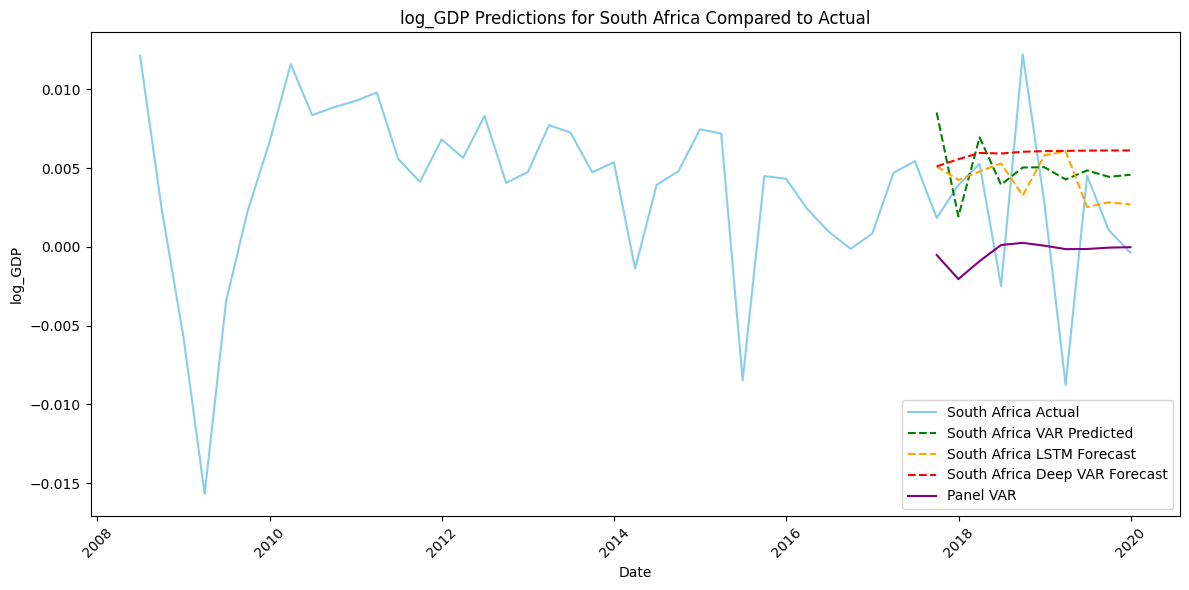

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


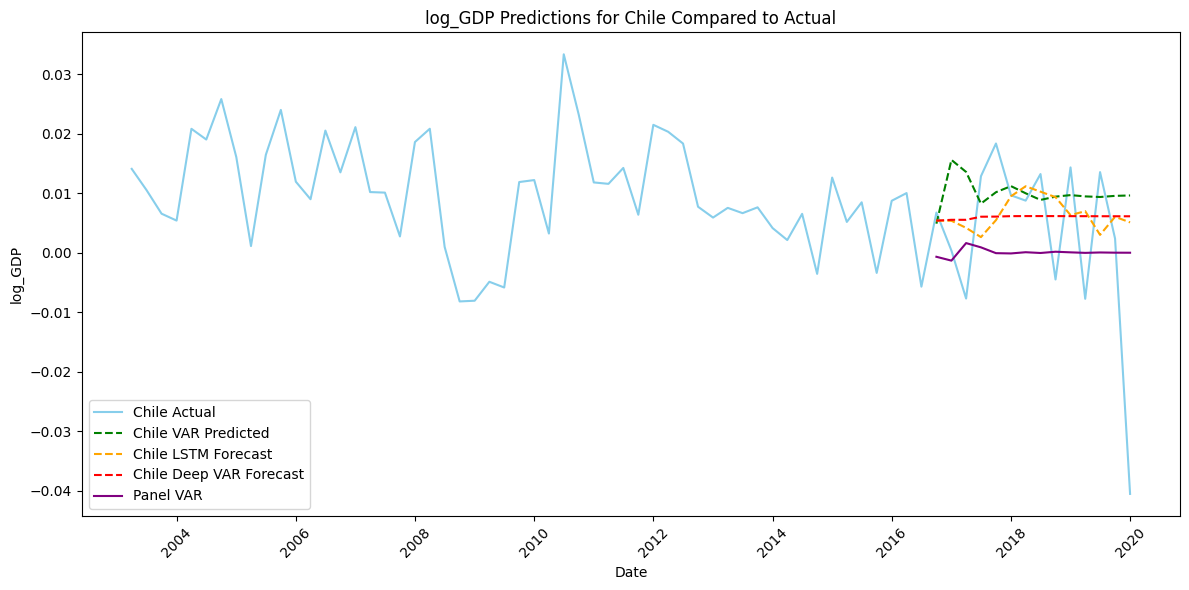

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


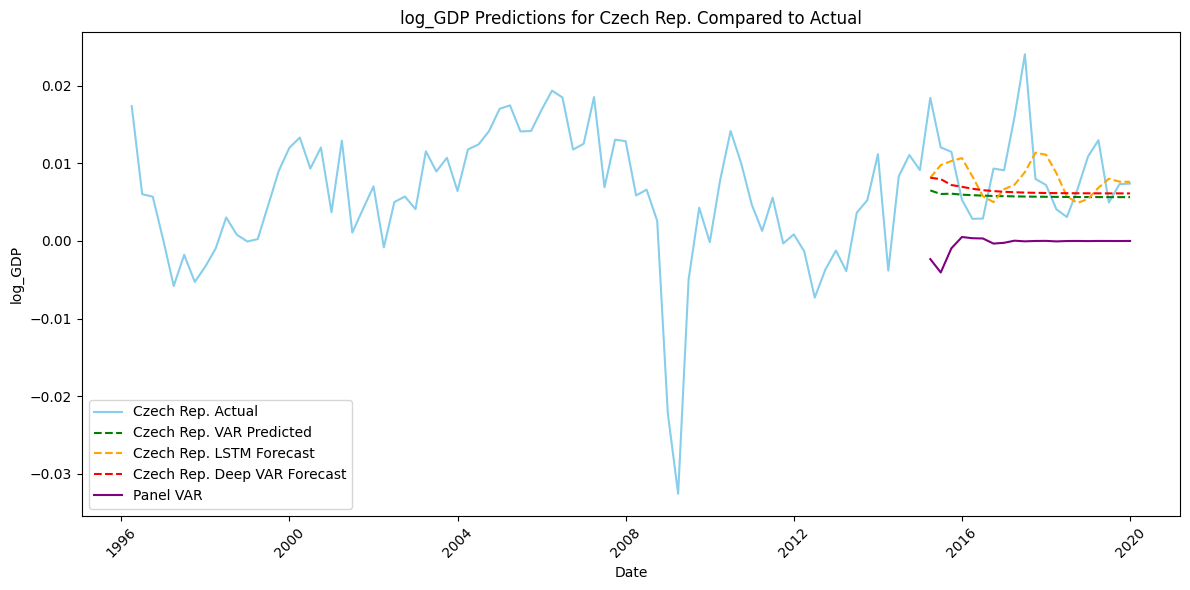

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


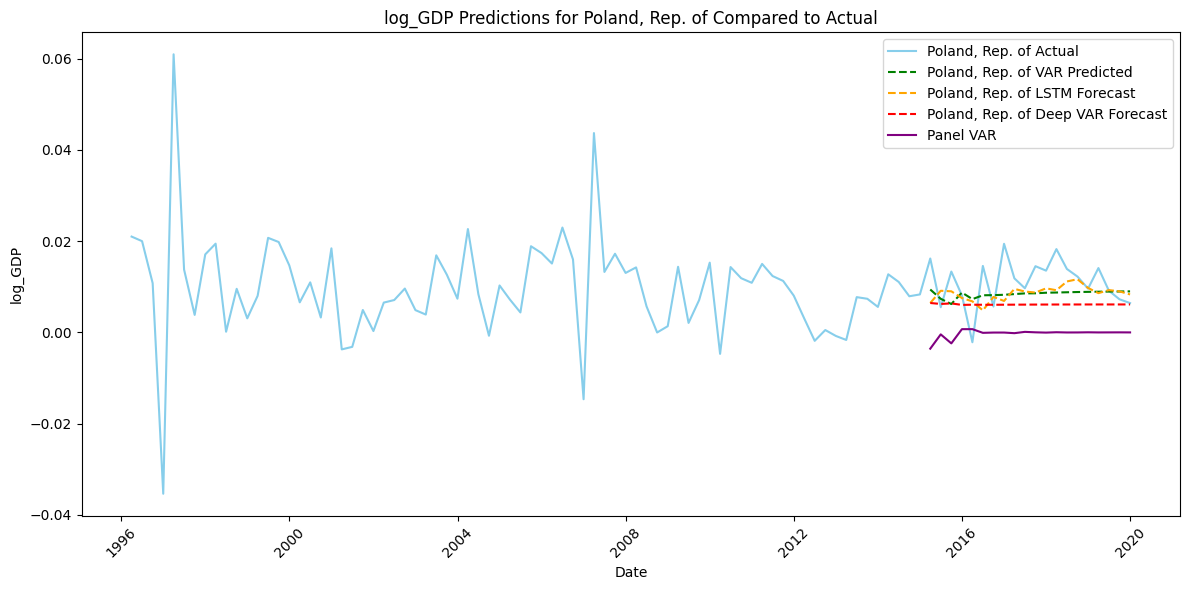

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


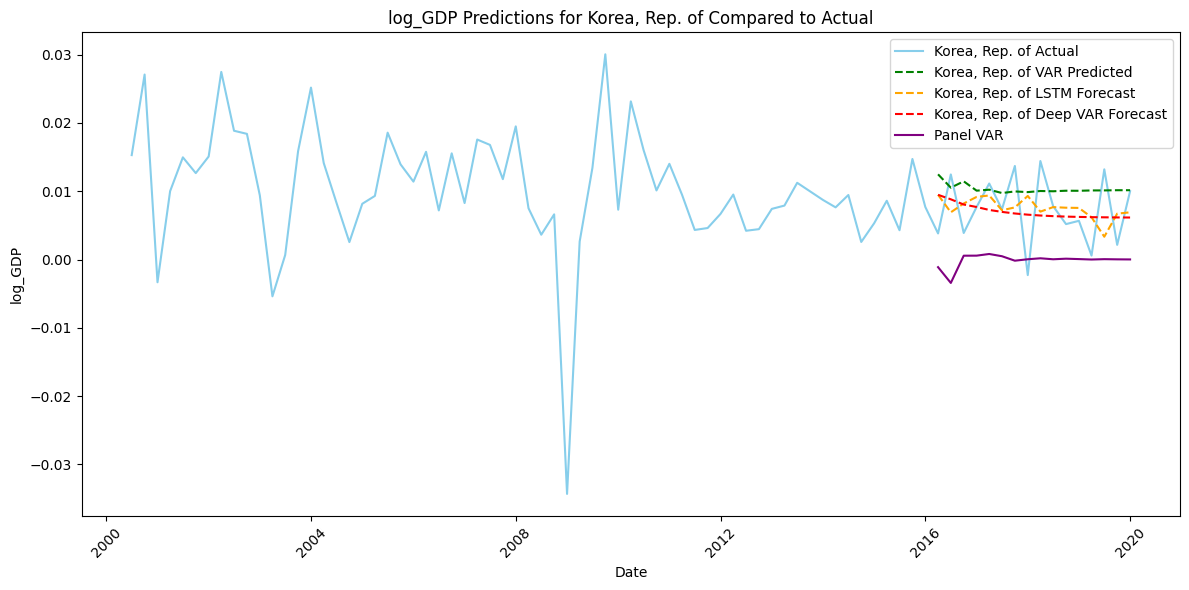

/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:48: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
Seed set to 18


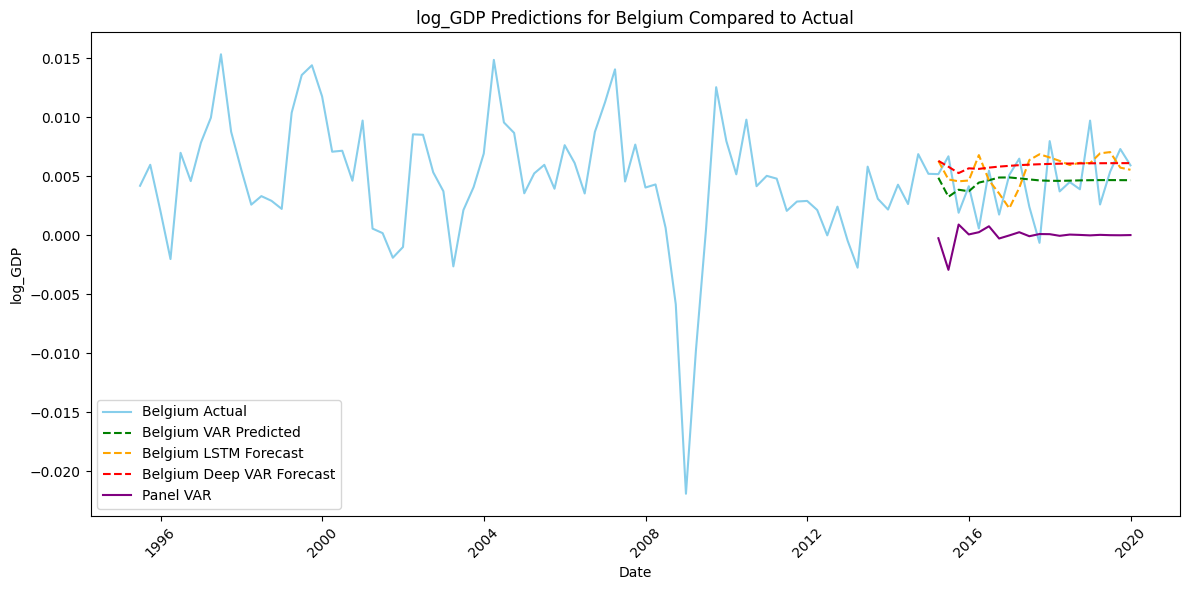

In [21]:
countries = ['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Germany', 'Brazil',
       'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Singapore', 'France',
       'Portugal', 'Hungary', 'Spain', 'Canada', 'Switzerland',
       'United States', 'Denmark', 'Indonesia', 'China, P.R.: Hong Kong',
       'Luxembourg', 'Japan', 'Finland', 'South Africa', 'Chile', 'Czech Rep.',
       'Poland, Rep. of', 'Korea, Rep. of', 'Belgium']

inputsvar = final_detrend.columns

panel_var_coef = pd.read_excel('coef.xlsx', index_col=0)

for country in countries:
    pr.plot_country_predictions_test(
        country, 
        'log_GDP', 
        inputs, 
        LAGS, 
        lstm_df, 
        model_scaler_dict, 
        train_dt_var,
        test_dt_var, 
        final_detrend,
        panel_var_coef
    )

## Appendix


In [22]:
# Test to ensure that detrending is 
# plt.figure(figsize = (12,9))
# plt.plot(df[df['Country']=='Colombia'].index, test1['Household debt'], label = 'Test')
# plt.plot(df[df['Country']=='Colombia'].index, df[df['Country']=='Colombia']['Household debt'], label = 'Real', color = 'orange')
# plt.plot(df_detrended[df_detrended['Country']=='Norway'].index, df_detrended[df_detrended['Country']=='Norway']['log_GDP'], label = 'Real', color = 'skyblue')

In [23]:
# Testing the model on other data. 

# Look into how it is determining the outcomes. Look at techniques. What part of the data is it looking at. 

In [24]:
final_detrend.describe()

summary_stats = df.describe().transpose()

latex_table = summary_stats.to_latex(float_format="%.5f")
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
log_GDP & 4765.00000 & 13.11645 & 2.18978 & 8.65451 & 11.89587 & 12.85612 & 13.79808 & 20.16631 \\
household_debt & 4765.00000 & 53.88753 & 29.39850 & 1.80000 & 34.00000 & 51.10000 & 69.70000 & 136.80000 \\
private_debt & 4765.00000 & 88.17279 & 51.59001 & 12.30000 & 56.20000 & 79.60000 & 107.70000 & 370.10000 \\
\bottomrule
\end{tabular}



In [25]:
num_variables_deepvar = len(inputs)
df_zeros = pd.DataFrame(np.zeros((1, num_variables_deepvar)), columns=inputs)


In [26]:
print(inputs)

# -3.50000 & -0.20000 & 0.20000 & 0.70000 & 4.40000

['log_GDP_lag1', 'log_GDP_lag2', 'log_GDP_lag3', 'household_debt_lag1', 'household_debt_lag2', 'household_debt_lag3', 'private_debt_lag1', 'private_debt_lag2', 'private_debt_lag3']


Small Change in Household debt % change effect on GDP

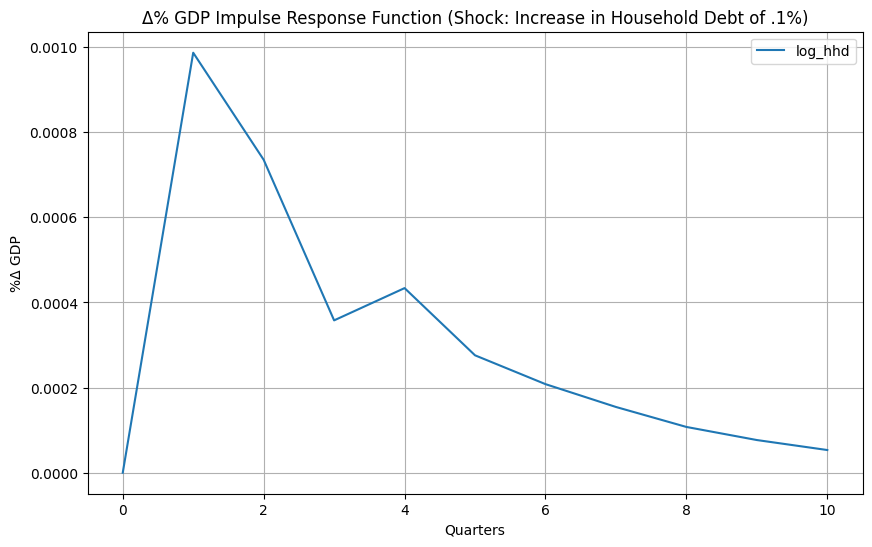

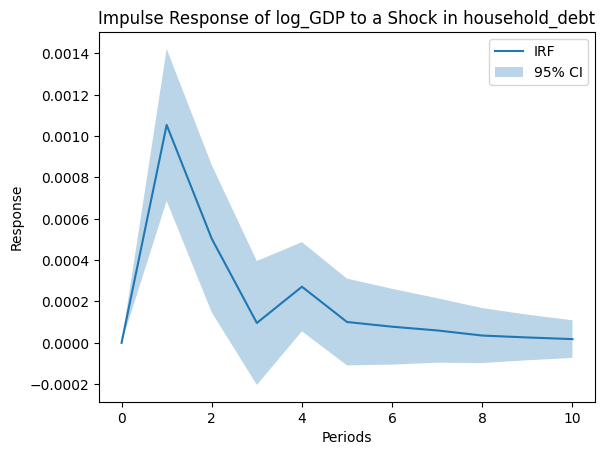

[[[ 7.00000000e-01  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  7.00000000e-01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  7.00000000e-01]]

 [[ 1.21175876e-01  1.05411291e-03 -1.56134265e-04]
  [-2.14822233e+00  2.57986497e-01 -2.91030004e-03]
  [-1.65201282e+01  2.87084049e-01  1.21841281e-01]]

 [[ 1.33610911e-01  5.03481876e-04 -8.94149942e-05]
  [-3.20044701e+00  2.86600702e-01 -5.68449993e-03]
  [-7.14031092e+00  1.85305538e-01  5.66248544e-02]]

 [[ 1.06036785e-01  9.59434522e-05 -1.00737447e-04]
  [-2.85741658e+00  2.13897007e-01 -7.80872513e-03]
  [-2.23893913e+00  1.17944409e-01  2.84524756e-02]]

 [[ 5.01582073e-02  2.71327961e-04 -7.06896976e-05]
  [-2.72083346e+00  1.68995427e-01 -5.26495316e-03]
  [-4.11854596e+00  1.29363456e-01  7.92727729e-03]]

 [[ 3.80003604e-02  1.00608228e-04 -4.60890642e-05]
  [-2.47918296e+00  1.35967667e-01 -4.49491678e-03]
  [-2.45698842e+00  9.26650104e-02  2.61594884e-03]]

 [[ 2.39180849e-02  7.78834974e-05 -3.18623564e-05]


In [27]:
plot1_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', .7, 'log_GDP', 10, model_scaler_dict)
plot1_title = 'Δ% GDP Impulse Response Function (Shock: Increase in Household Debt of .1%)'
plot1_var = '%Δ GDP'
irf.plot(plot1_irf_results, 'log_hhd', plot1_title, plot1_var)

from statsmodels.tsa.api import VAR
shock_size = 0.7

test2 = VAR(final_detrend)
test2_results = test2.fit(maxlags=3)
var_irf = test2_results.irf(10)

scaled_irf = var_irf.irfs * shock_size
scaled_stderr = var_irf.stderr(orth=False) * shock_size  

response_index = test2_results.names.index('household_debt')
impulse_index = test2_results.names.index('log_GDP')

irf_values = scaled_irf[:, impulse_index, response_index]
irf_stderr = scaled_stderr[:, impulse_index, response_index]

alpha = 0.05
z_score = 1.96  
lower_ci = irf_values - z_score * irf_stderr
upper_ci = irf_values + z_score * irf_stderr

plt.plot(irf_values, label='IRF')
plt.fill_between(range(len(irf_values)), lower_ci, upper_ci, alpha=0.3, label='95% CI')
plt.title('Impulse Response of log_GDP to a Shock in household_debt')
plt.xlabel('Periods')
plt.ylabel('Response')
plt.legend()
plt.show()
print(scaled_irf)

Average Change in Household debt % change effect on GDP

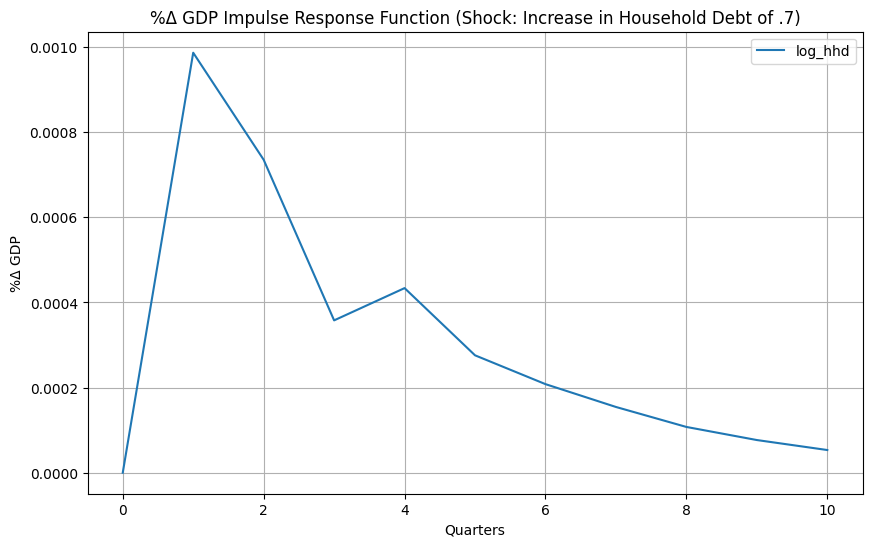

In [28]:
plot2_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', 0.70000, 'log_GDP', 10, model_scaler_dict)
plot2_title = '%Δ GDP Impulse Response Function (Shock: Increase in Household Debt of .7)'
plot2_var = '%Δ GDP'
irf.plot(plot2_irf_results, 'log_hhd', plot2_title, plot2_var)

Large Change in Household debt % change effect on GDP

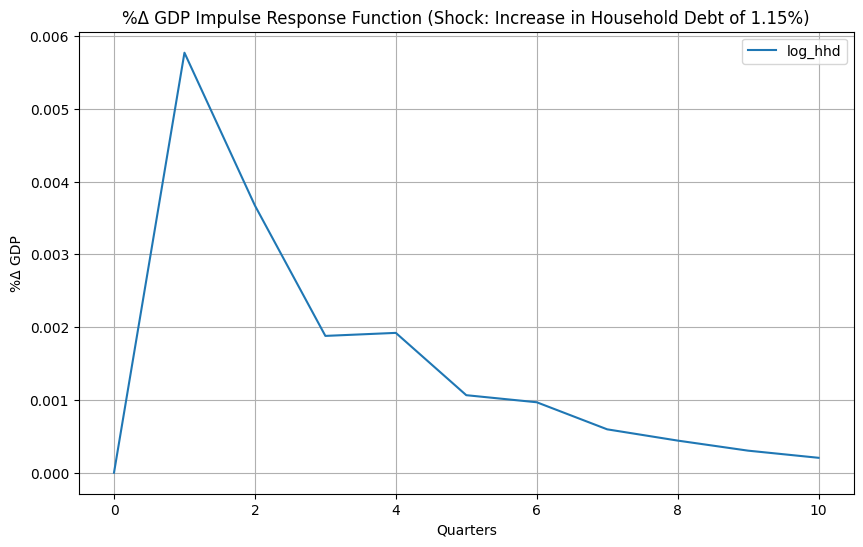

In [29]:
plot3_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', 4.4, 'log_GDP', 10, model_scaler_dict)
plot3_title = '%Δ GDP Impulse Response Function (Shock: Increase in Household Debt of 1.15%)'
plot3_var = '%Δ GDP'

irf.plot(plot3_irf_results, 'log_hhd', plot3_title, plot3_var)

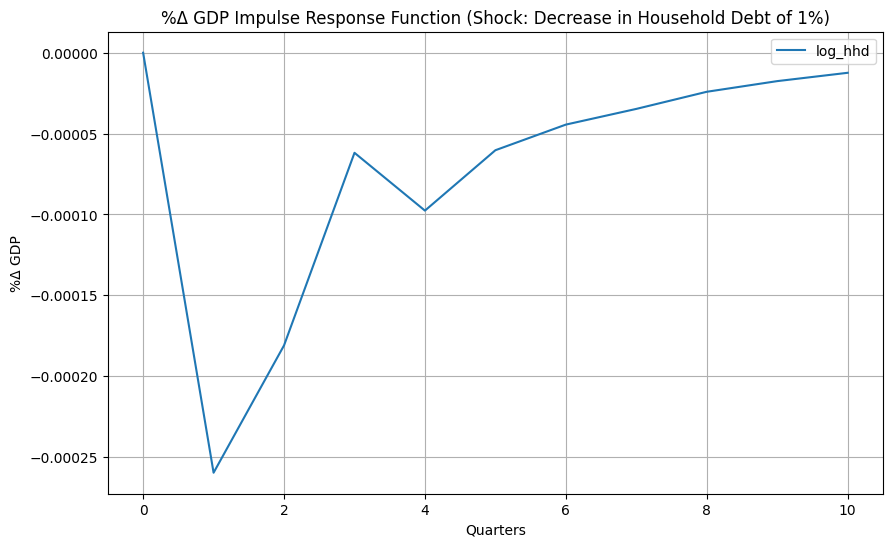

In [30]:
plot4_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', -.2, 'log_GDP', 10, model_scaler_dict)
plot4_title = '%Δ GDP Impulse Response Function (Shock: Decrease in Household Debt of 1%)'
plot4_var = '%Δ GDP'


irf.plot(plot4_irf_results, 'log_hhd', plot4_title, plot4_var)

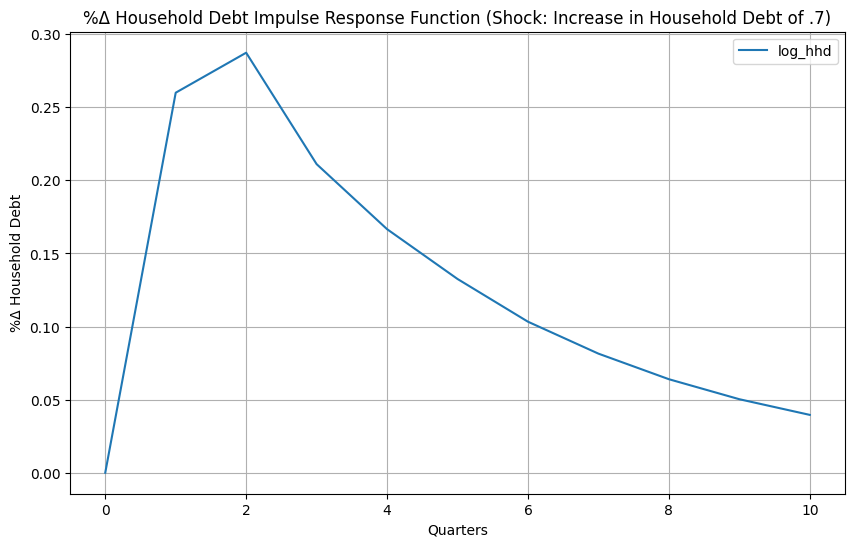

In [31]:
plot5_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', .7, 'household_debt', 10, model_scaler_dict)
plot5_title = '%Δ Household Debt Impulse Response Function (Shock: Increase in Household Debt of .7)'
plot5_var = '%Δ Household Debt'


irf.plot(plot5_irf_results, 'log_hhd', plot5_title, plot5_var)

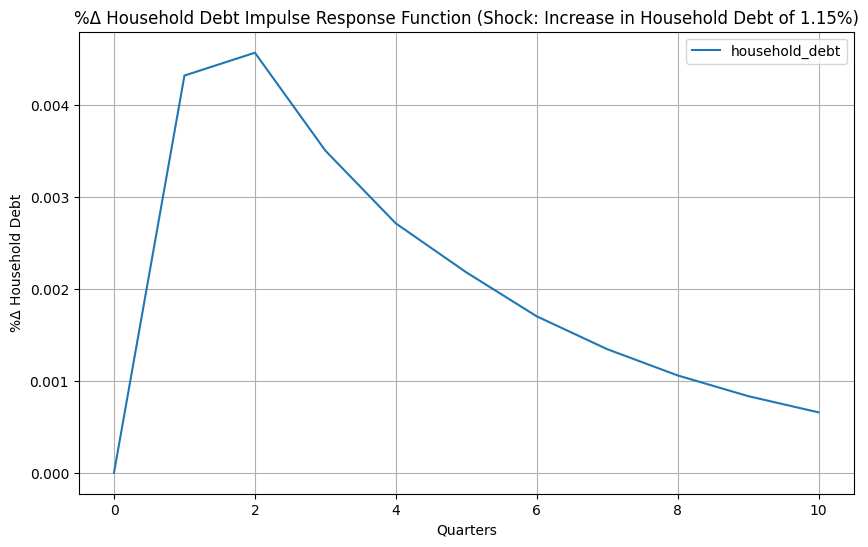

In [32]:
plot6_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', .0115, 'household_debt', 10, model_scaler_dict)
plot6_title = '%Δ Household Debt Impulse Response Function (Shock: Increase in Household Debt of 1.15%)'
plot6_var = '%Δ Household Debt'


irf.plot(plot6_irf_results, 'household_debt', plot6_title, plot6_var)


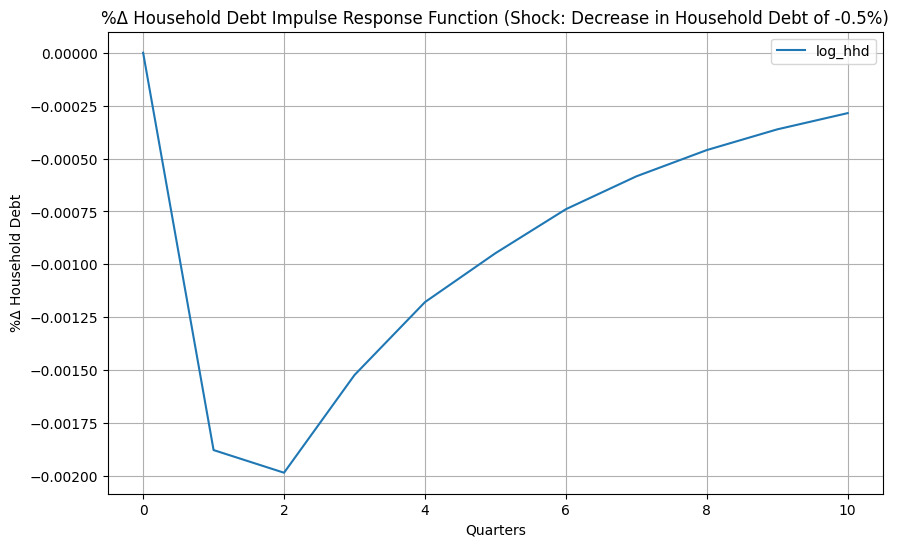

In [33]:
plot6_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', -.005, 'household_debt', 10, model_scaler_dict)
plot6_title = '%Δ Household Debt Impulse Response Function (Shock: Decrease in Household Debt of -0.5%)'
plot6_var = '%Δ Household Debt'


irf.plot(plot6_irf_results, 'log_hhd', plot6_title, plot6_var)

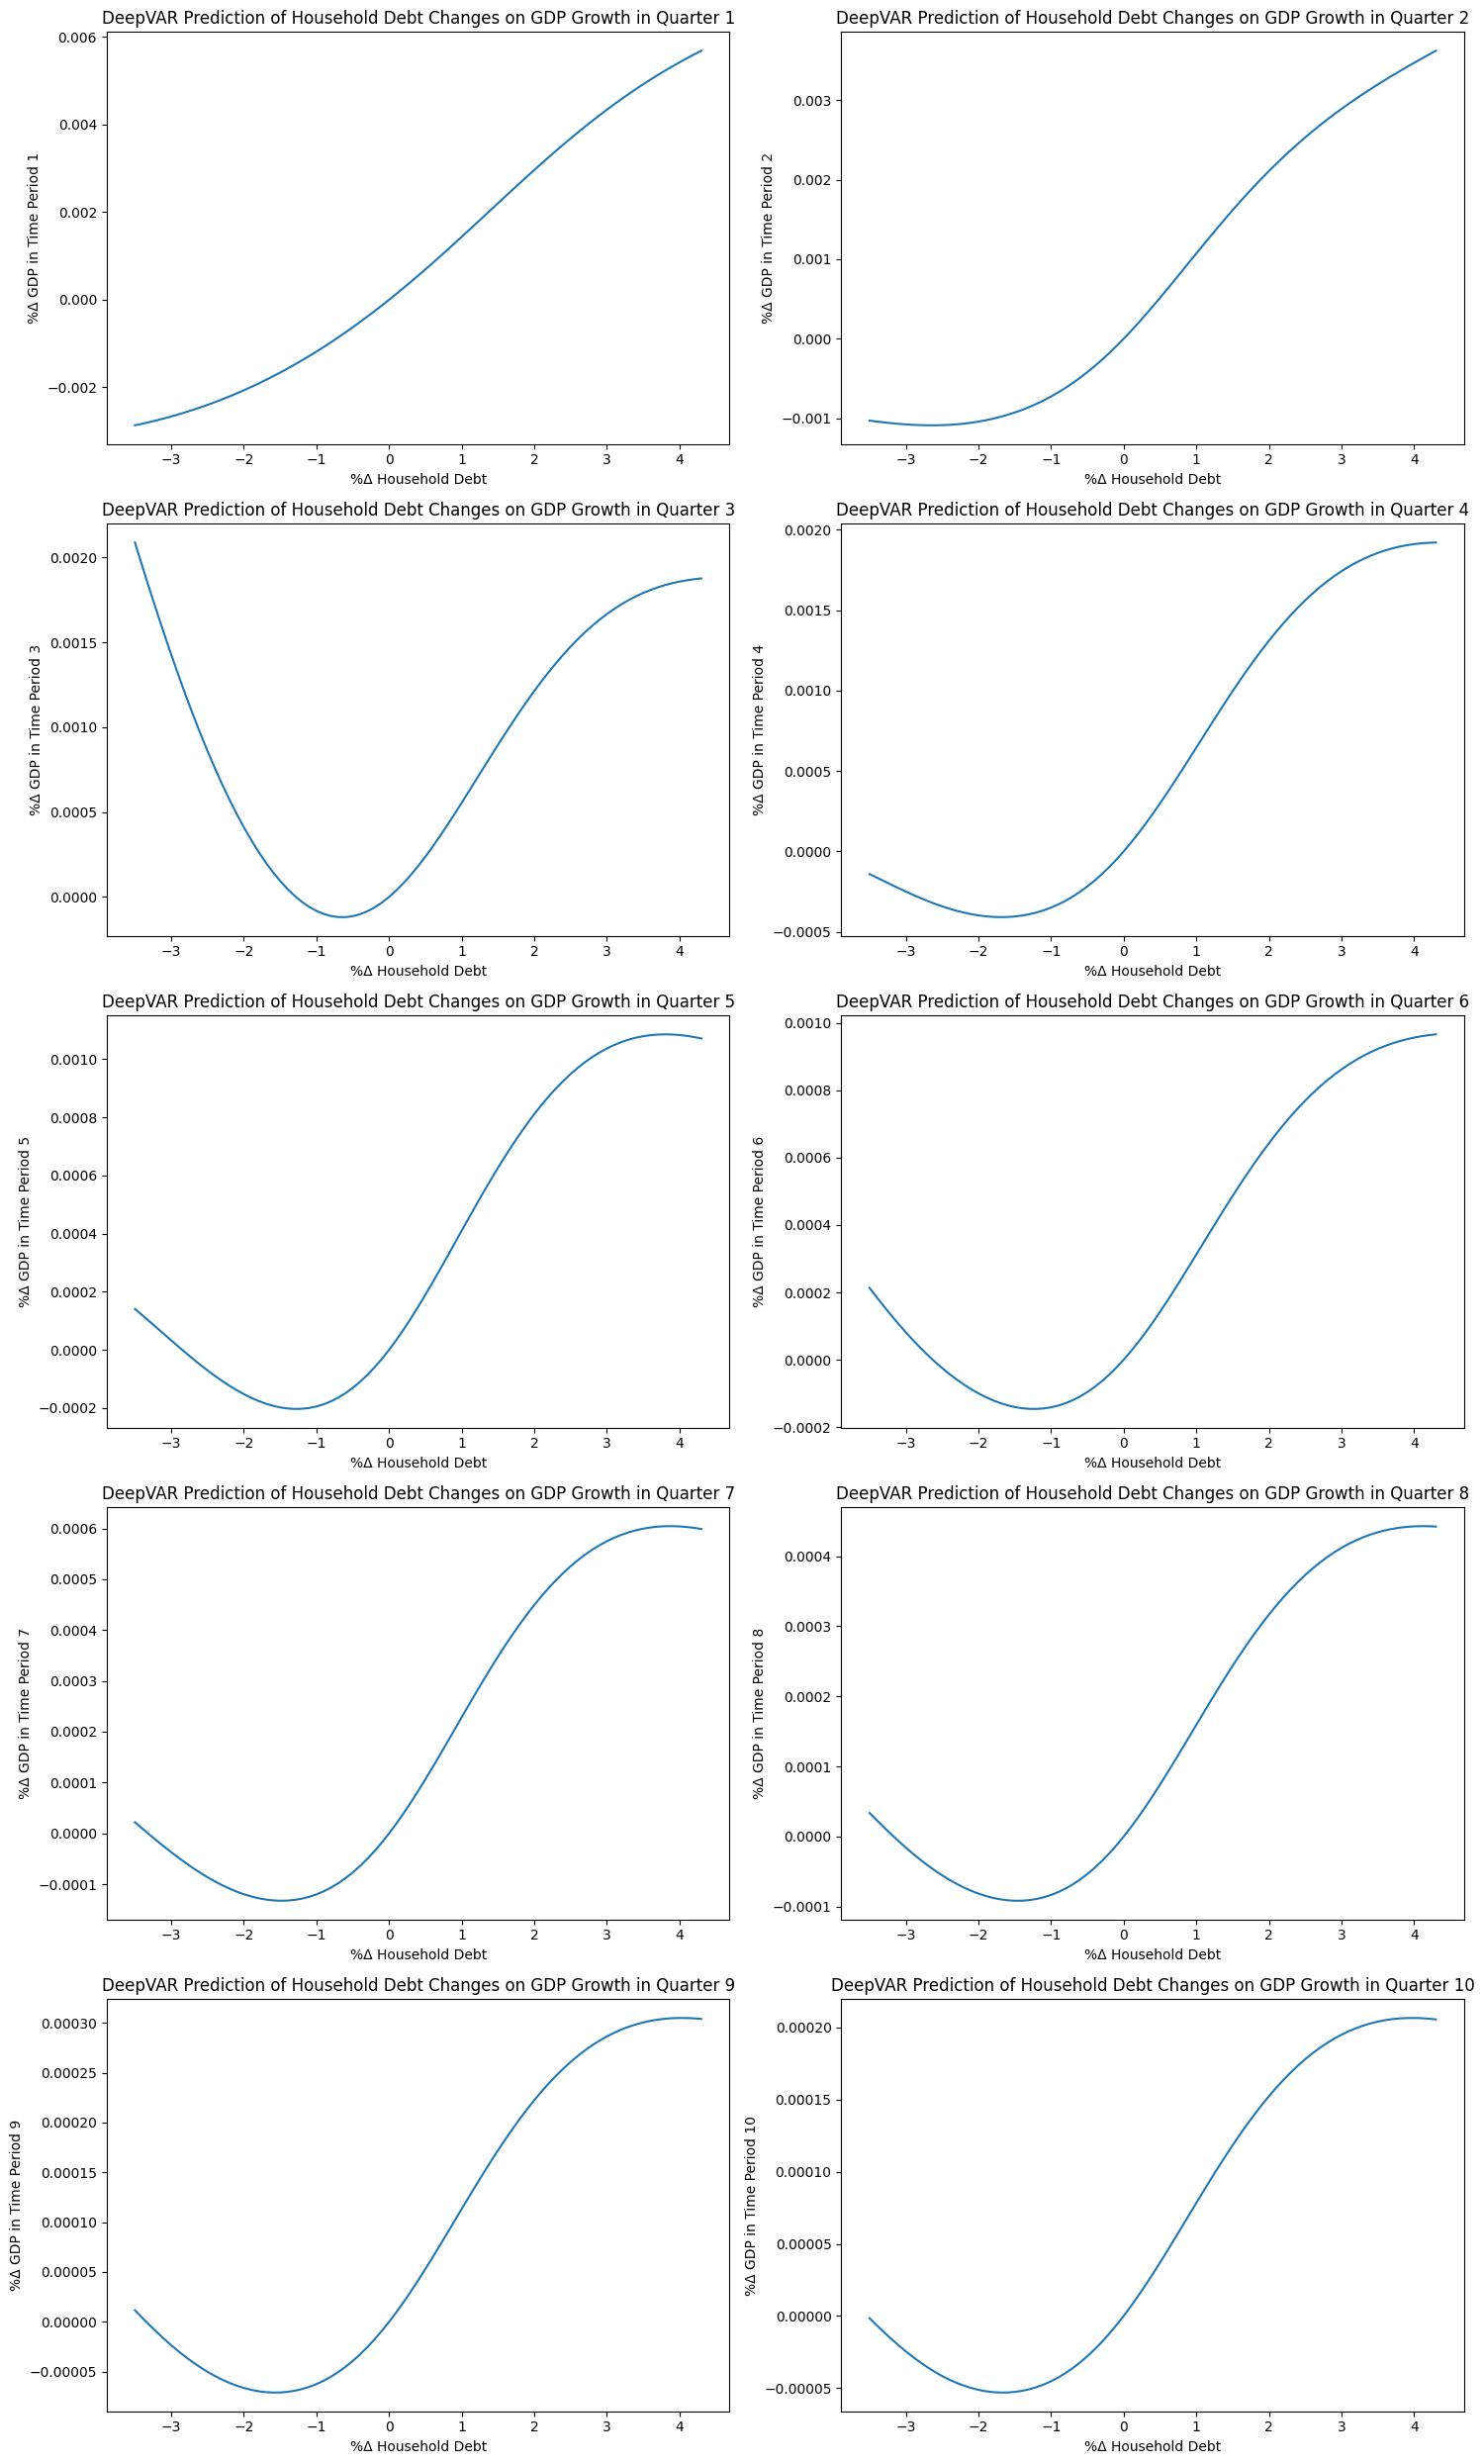

In [34]:
onesteppredictions = []
twosteppredictions = []
threesteppredictions = []
foursteppredictions = []
fivesteppredictions = []
sixsteppredictions = []
sevensteppredictions = []
eightsteppredictions = []
ninesteppredictions = []
tensteppredictions = []
index = []
for num in np.arange(-3.5,4.4, 0.1):
    prediction = irf.predict(df_zeros, inputs, 'household_debt_lag1', num, 'log_GDP', 10, model_scaler_dict)
    # irf begins at 0 
    onesteppredictions.append(prediction[1])
    twosteppredictions.append(prediction[2])
    threesteppredictions.append(prediction[3])
    foursteppredictions.append(prediction[4])
    fivesteppredictions.append(prediction[5])
    sixsteppredictions.append(prediction[6])
    sevensteppredictions.append(prediction[7])
    eightsteppredictions.append(prediction[8])
    ninesteppredictions.append(prediction[9])
    tensteppredictions.append(prediction[10])
    index.append(num)



fig, axs = plt.subplots(5, 2, figsize=(15, 25))  
axs = axs.ravel() 

predictions_list = [onesteppredictions, twosteppredictions, threesteppredictions, 
                   foursteppredictions, fivesteppredictions, sixsteppredictions,
                   sevensteppredictions, eightsteppredictions, ninesteppredictions,
                   tensteppredictions]

for i in range(10):
    axs[i].plot(index, predictions_list[i])
    axs[i].set_xlabel("%Δ Household Debt")
    axs[i].set_ylabel(f"%Δ GDP in Time Period {i+1}")
    axs[i].set_title(f"DeepVAR Prediction of Household Debt Changes on GDP Growth in Quarter {i+1}")

plt.tight_layout() 
plt.show()

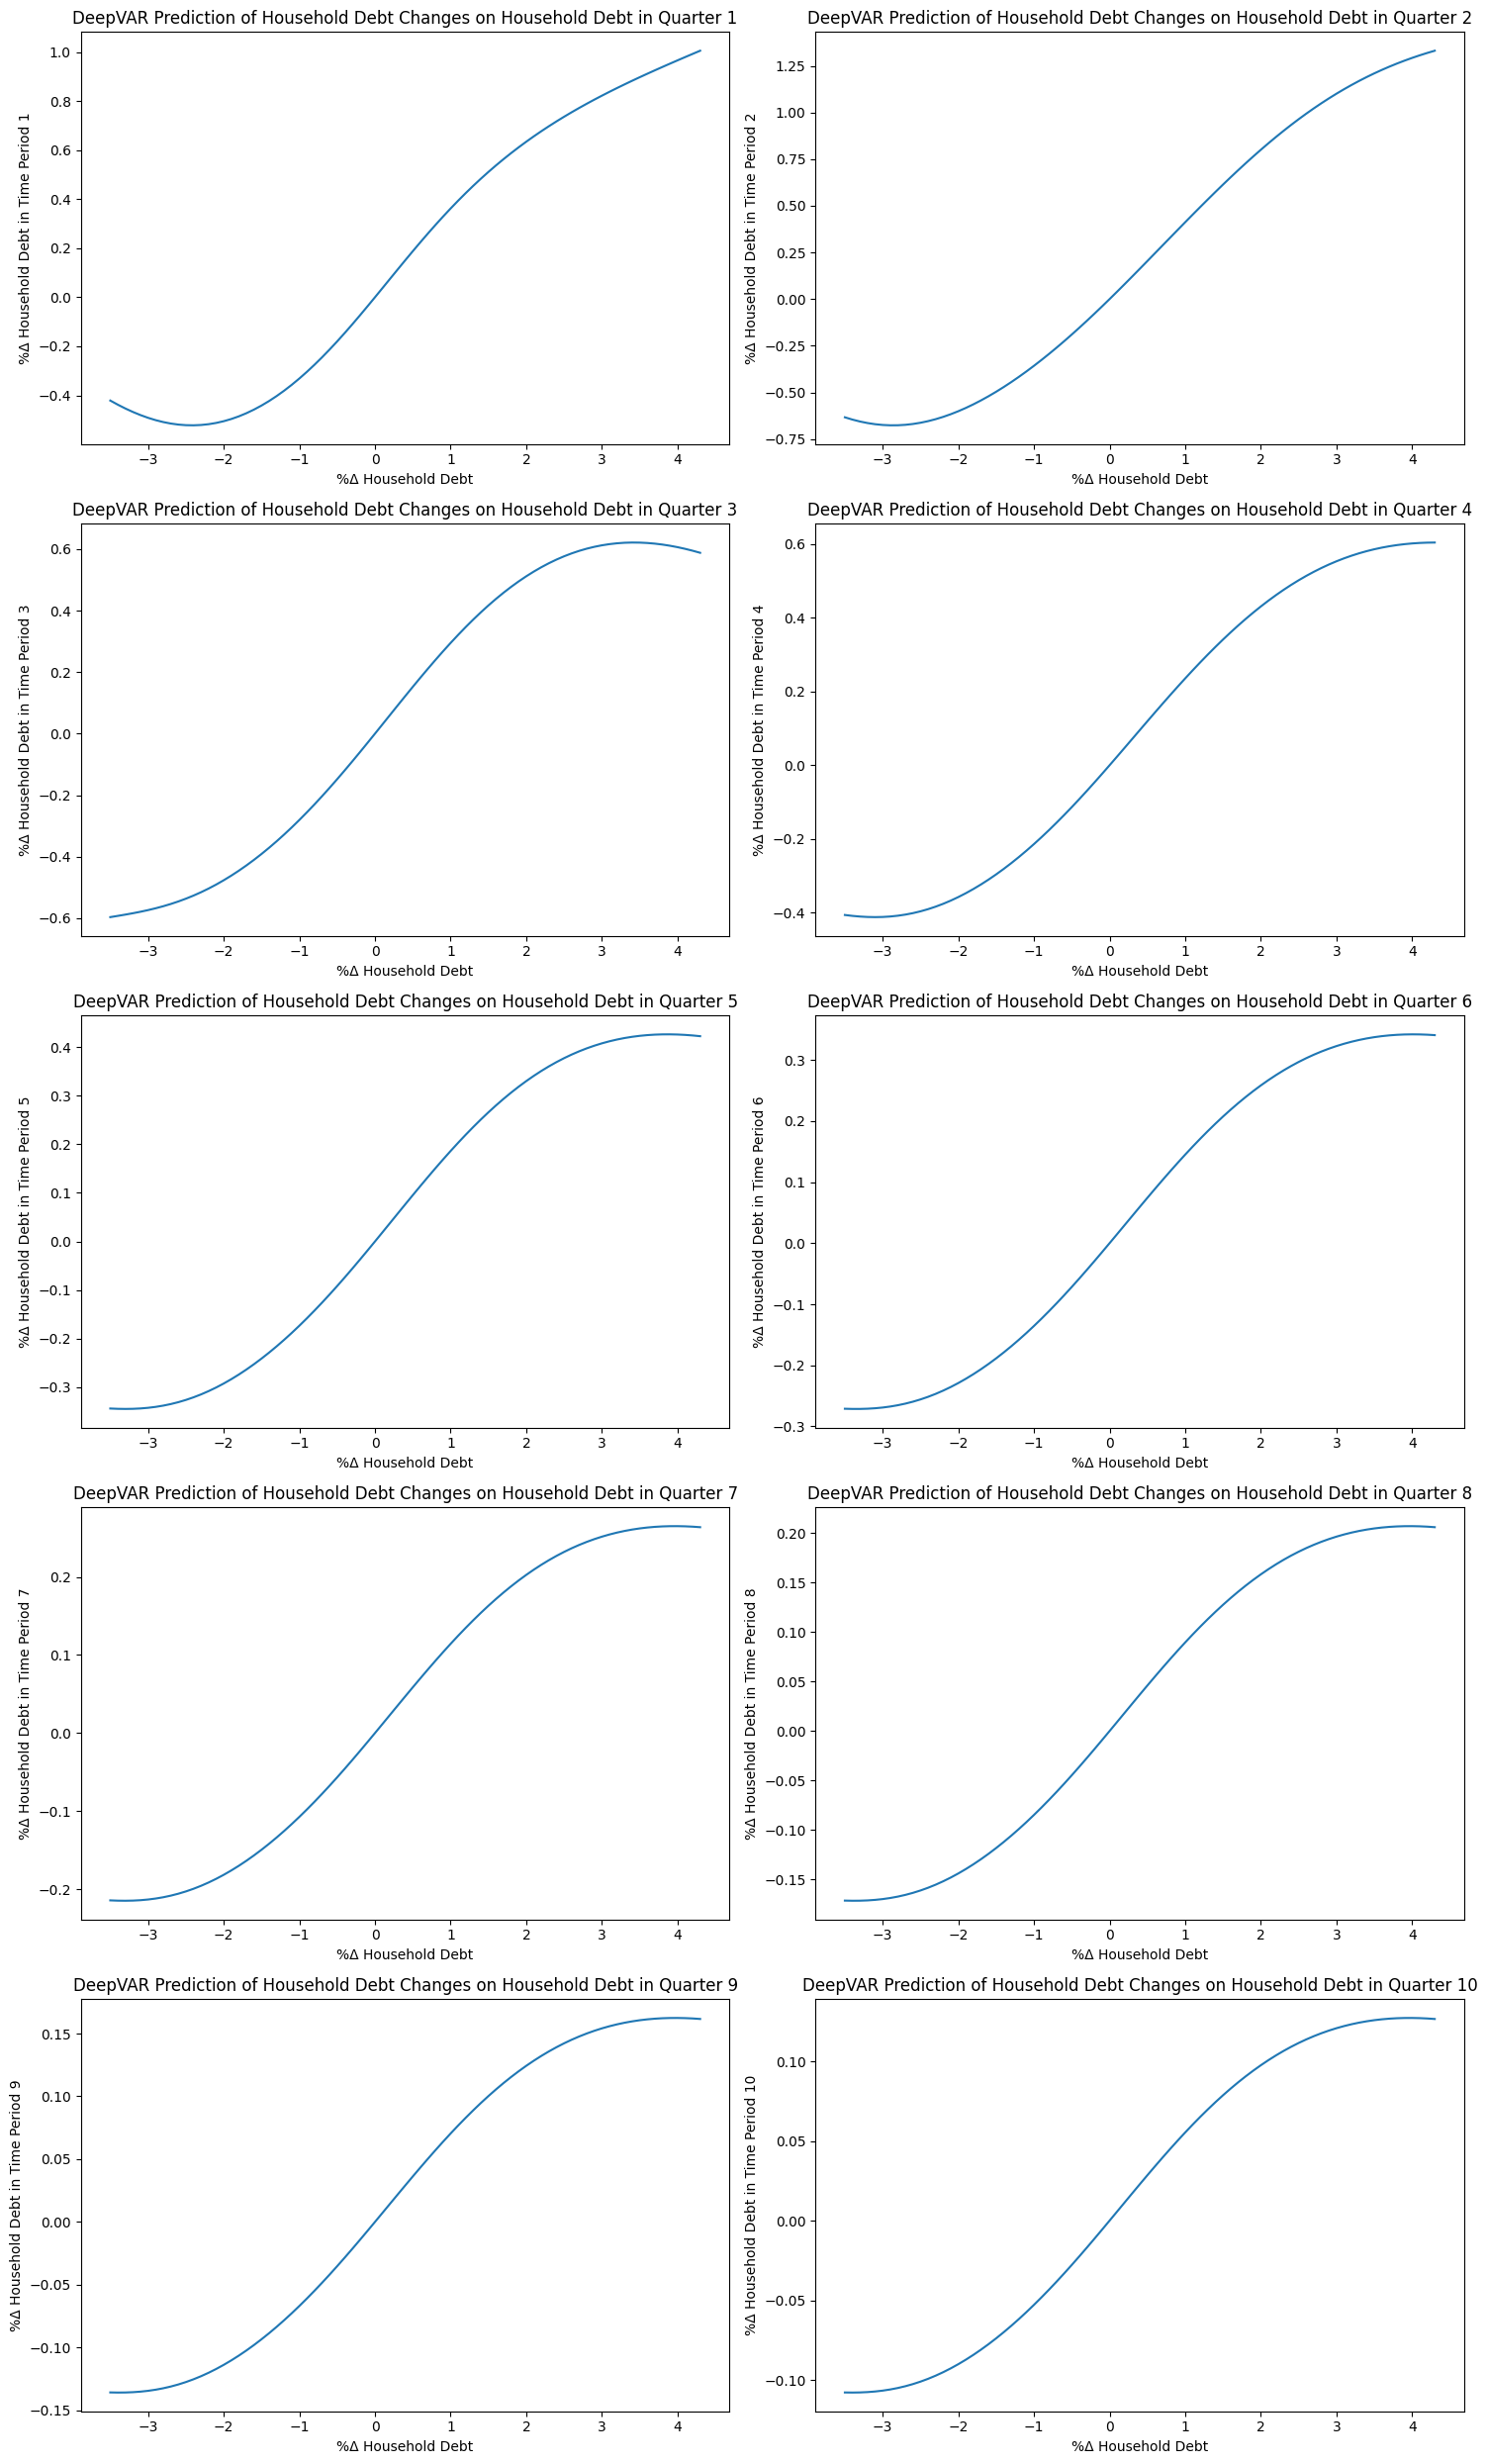

In [35]:
onesteppredictions = []
twosteppredictions = []
threesteppredictions = []
foursteppredictions = []
fivesteppredictions = []
sixsteppredictions = []
sevensteppredictions = []
eightsteppredictions = []
ninesteppredictions = []
tensteppredictions = []
index = []
for num in np.arange(-3.50000, 4.4, .1):
    prediction = irf.predict(df_zeros, inputs, 'household_debt_lag1', num, 'household_debt', 10, model_scaler_dict)
    # irf begins at 0 
    onesteppredictions.append(prediction[1])
    twosteppredictions.append(prediction[2])
    threesteppredictions.append(prediction[3])
    foursteppredictions.append(prediction[4])
    fivesteppredictions.append(prediction[5])
    sixsteppredictions.append(prediction[6])
    sevensteppredictions.append(prediction[7])
    eightsteppredictions.append(prediction[8])
    ninesteppredictions.append(prediction[9])
    tensteppredictions.append(prediction[10])
    index.append(num)



fig, axs = plt.subplots(5, 2, figsize=(15, 25))  
axs = axs.ravel() 

predictions_list = [onesteppredictions, twosteppredictions, threesteppredictions, 
                   foursteppredictions, fivesteppredictions, sixsteppredictions,
                   sevensteppredictions, eightsteppredictions, ninesteppredictions,
                   tensteppredictions]

for i in range(10):
    axs[i].plot(index, predictions_list[i])
    axs[i].set_xlabel("%Δ Household Debt")
    axs[i].set_ylabel(f"%Δ Household Debt in Time Period {i+1}")
    axs[i].set_title(f"DeepVAR Prediction of Household Debt Changes on Household Debt in Quarter {i+1}")

plt.tight_layout() 
plt.show()

In [36]:
# onesteppredictions = []
# twosteppredictions = []
# threesteppredictions = []
# foursteppredictions = []
# fivesteppredictions = []
# sixsteppredictions = []
# sevensteppredictions = []
# eightsteppredictions = []
# ninesteppredictions = []
# tensteppredictions = []
# index = []
# for num in np.arange(-3.50000,4.4, 0.1):
#     prediction = irf.predict(df_zeros, inputs, 'household_debt_lag1', num, 'log_CPI', 10, model_scaler_dict)
#     # irf begins at 0 
#     onesteppredictions.append(prediction[1])
#     twosteppredictions.append(prediction[2])
#     threesteppredictions.append(prediction[3])
#     foursteppredictions.append(prediction[4])
#     fivesteppredictions.append(prediction[5])
#     sixsteppredictions.append(prediction[6])
#     sevensteppredictions.append(prediction[7])
#     eightsteppredictions.append(prediction[8])
#     ninesteppredictions.append(prediction[9])
#     tensteppredictions.append(prediction[10])
#     index.append(num)



# fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # 5x2 grid of subplots
# axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

# predictions_list = [onesteppredictions, twosteppredictions, threesteppredictions, 
#                    foursteppredictions, fivesteppredictions, sixsteppredictions,
#                    sevensteppredictions, eightsteppredictions, ninesteppredictions,
#                    tensteppredictions]

# for i in range(10):
#     axs[i].plot(index, predictions_list[i])
#     axs[i].set_xlabel("%Δ Household Debt")
#     axs[i].set_ylabel(f"%Δ CPI in Time Period {i+1}")
#     axs[i].set_title(f"DeepVAR Prediction of Household Debt Changes on CPI in Quarter {i+1}")

# plt.tight_layout() 
# plt.show()

In [37]:
au = hp.get_country(final_detrend, 'Australia')
au[au.index.get_level_values('TIME_PERIOD') == '2008-03-31']

log_GDP  household_debt  private_debt
Country   TIME_PERIOD                                       
Australia 2008-03-31   0.01071             0.1           0.9

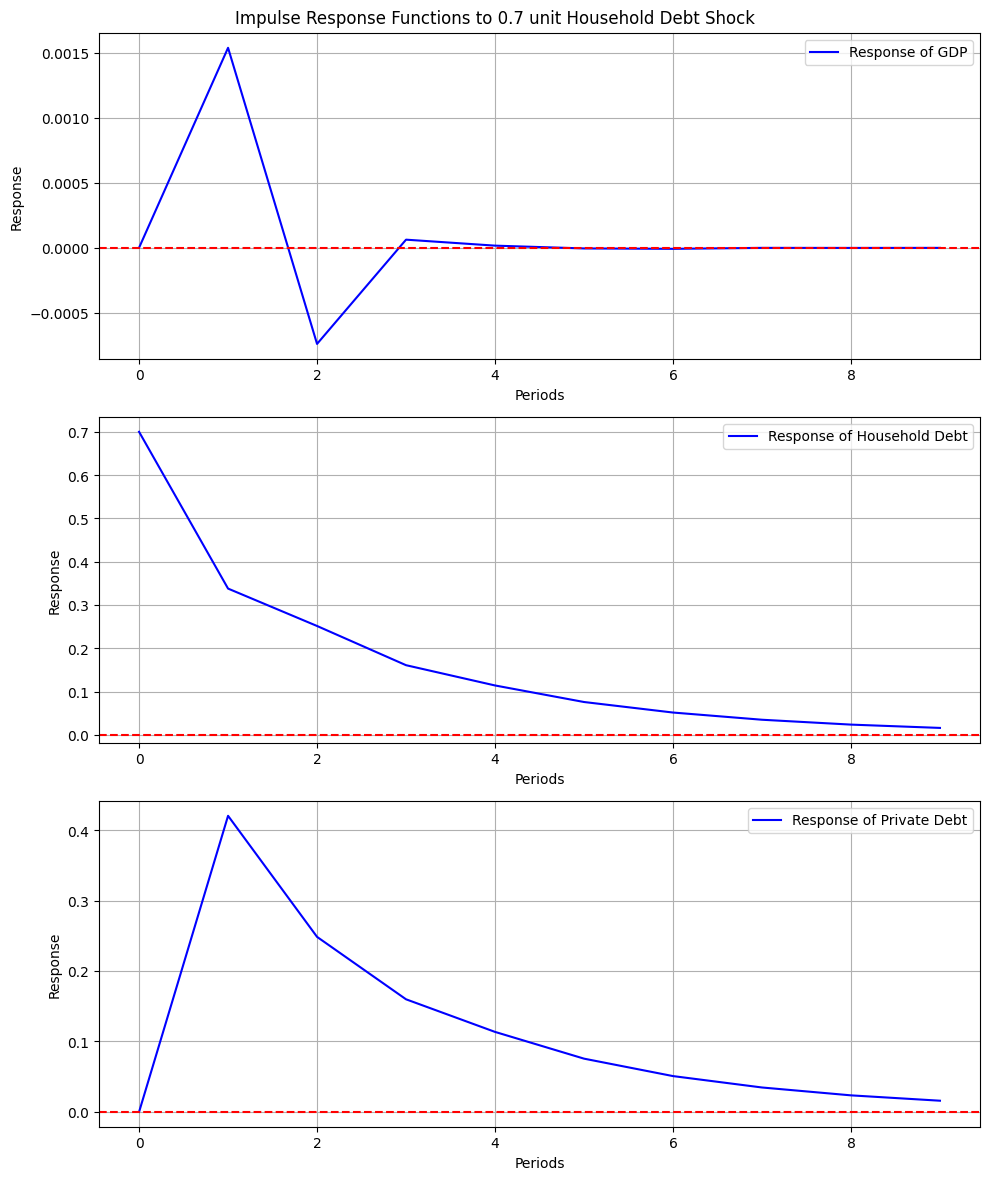

In [ ]:
fig, irf_results = pvar.generate_irf_from_coefficients(
    panel_var_coef,
    shock_var=1, 
    shock_size=.7,  
    periods=10
)


In [40]:
final_detrend

log_GDP  household_debt  private_debt
Country  TIME_PERIOD                                        
Colombia 2005-06-30   0.020220           0.494        -0.682
         2005-09-30  -0.000439           0.320        -0.743
         2005-12-31   0.018095           0.690        -0.278
         2006-03-31   0.021254          -0.076        -0.160
         2006-06-30   0.016457           0.713         0.660
...                        ...             ...           ...
Belgium  2018-12-31   0.009724           0.300         0.900
         2019-03-31   0.002609           0.400        -0.200
         2019-06-30   0.005386           0.300        -0.900
         2019-09-30   0.007315           0.000         2.300
         2019-12-31   0.005931           0.700        -1.400

[4065 rows x 3 columns]